In [2]:
from vtl.Readfile import Readfile
from vtl.Photo import Photometry
from spec_id import Analyze_LH_lwa, Error,Oldest_galaxy, Gen_spec, Stack,Median_model, \
    Median_w_Error,Median_w_Error_cont,Likelihood_contours,Gen_sim, Stack_posteriors, Linear_fit , \
    Median_w_Error_95,Gen_grid, Iterative_stacking, Gauss_dist
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
colors = [(0,i,i,i) for i in np.linspace(0,1,3)]
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)
pandas2ri.activate()

In [3]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126 and ids != 48631')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [24]:
print np.round(min(lzDB['lmass']),1),np.round(max(lzDB['lmass']),1)
print np.round(min(mzDB['lmass']),1),np.round(max(mzDB['lmass']),1)
print np.round(min(hzDB['lmass']),1),np.round(max(hzDB['lmass']),1)
print np.round(min(uhzDB['lmass']),1),np.round(max(uhzDB['lmass']),1)

10.1 11.1
10.6 11.2
10.2 10.9
10.3 11.1


In [33]:
galDB

,gids,ids,ra,dec,hi_res_specz,lmass,tau,Z_f,Z_-_sig_f,Z_+_sig_f,...,t_+_sig_cal,tx_cal,tx_-_sig_cal,tx_+_sig_cal,Zx_cal,Zx_-_sig_cal,Zx_+_sig_cal,Z_cal,Z_-_sig_cal,Z_+_sig_cal
49,n16758,16758,189.162357,62.224840,1.014,10.83,0.00,0.020,0.001,0.002,...,0.666,3.916834,0.716433,0.749499,0.013952,0.001852,0.002693,0.014,0.002,0.003
50,n17070,17070,189.268086,62.226445,1.192,10.92,8.48,0.011,0.003,0.004,...,0.516,2.043086,0.518036,0.573146,0.011427,0.002918,0.006565,0.012,0.003,0.006
58,n19442,19442,189.123036,62.237460,1.101,10.10,8.90,0.015,0.009,0.010,...,1.041,2.583166,0.771543,1.058116,0.013671,0.008192,0.010717,0.014,0.009,0.010
61,n21156,21156,189.239409,62.247548,1.251,11.16,8.30,0.020,0.005,0.004,...,0.307,2.098196,0.418838,0.308617,0.023884,0.003928,0.003984,0.024,0.004,0.004
62,n21427,21427,189.368121,62.247344,1.514,10.73,8.48,0.019,0.010,0.007,...,0.514,2.329659,0.584168,0.584168,0.017543,0.008810,0.008529,0.018,0.009,0.008
69,n23435,23435,189.338306,62.256571,1.134,10.27,8.60,0.014,0.006,0.009,...,0.827,3.112224,0.760521,0.914830,0.012044,0.005780,0.010156,0.013,0.007,0.009
86,n32566,32566,189.161280,62.307577,1.150,10.61,8.70,0.020,0.008,0.006,...,0.395,2.032064,0.683367,0.462926,0.021190,0.008136,0.006004,0.022,0.009,0.005
96,n34694,34694,189.147840,62.323647,1.145,10.94,8.30,0.015,0.006,0.005,...,0.963,2.803607,0.462926,0.958918,0.014345,0.004882,0.005667,0.015,0.006,0.005
107,n37686,37686,189.274474,62.360820,1.258,10.89,8.48,0.016,0.003,0.004,...,0.751,3.068136,0.473948,0.782565,0.014681,0.003928,0.005667,0.015,0.004,0.005
212,s35774,35774,53.158775,-27.742385,1.223,10.86,8.90,0.008,0.003,0.003,...,0.378,2.803607,0.859719,0.473948,0.008397,0.004433,0.009876,0.009,0.005,0.009


# Mass histogram


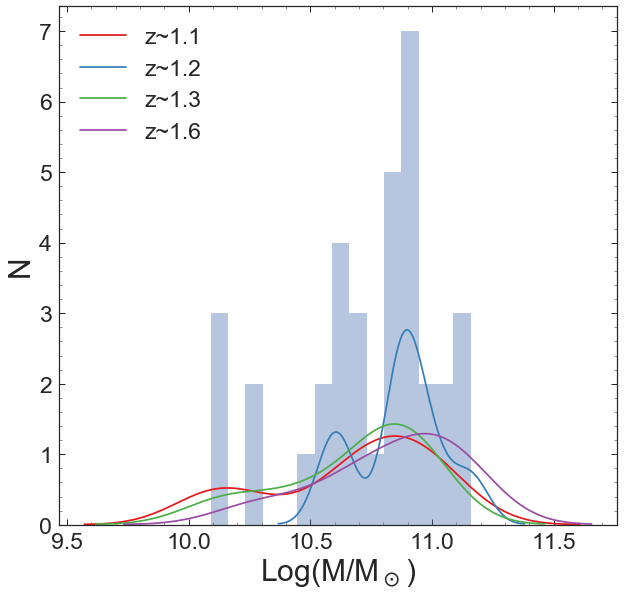

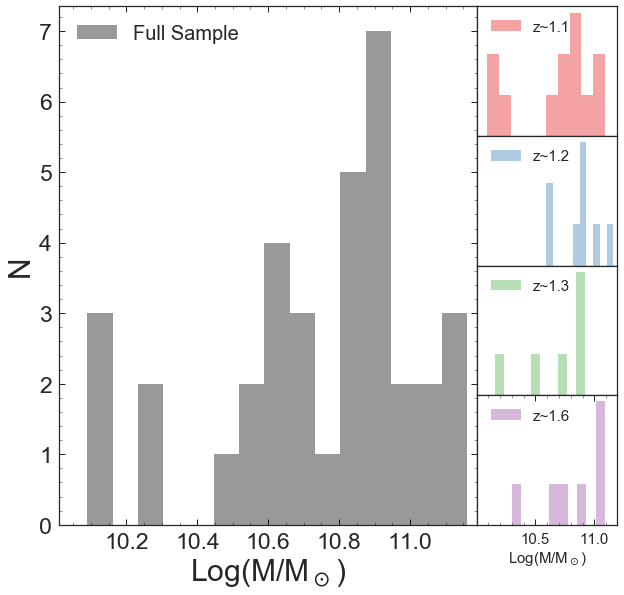

In [47]:
%matplotlib inline
plt.figure(figsize=[10,10])
sea.distplot(galDB['lmass'],kde=False,bins=15)
sea.distplot(lzDB['lmass'],color='#e41a1c',hist=False,label='z~1.1')
sea.distplot(mzDB['lmass'],color='#377eb8',hist=False,label='z~1.2')
sea.distplot(hzDB['lmass'],color='#4daf4a',hist=False,label='z~1.3')
sea.distplot(uhzDB['lmass'],color='#984ea3',hist=False,label='z~1.6')
# plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2,fontsize=23)
plt.xlabel('Log(M/M$_\odot$)',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.show()
plt.savefig('../plots/mass_hist1.pdf',bbox_inches = 'tight')
plt.close

gs = gridspec.GridSpec(4,2,width_ratios=[3,1],wspace=0,hspace=0)

plt.figure(figsize=[10,10])
plt.subplot(gs[:,:-1])
sea.distplot(galDB['lmass'],kde=False,bins=15,color='k',label = 'Full Sample')
plt.xlim(10.01,11.19)
plt.xlabel('Log(M/M$_\odot$)',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.legend(loc=2,fontsize=20)


plt.subplot(gs[0,1])
sea.distplot(lzDB['lmass'],color='#e41a1c',kde=False,label='z~1.1',bins=10)
plt.yticks([])
plt.xticks([])
plt.xlim(10.01,11.19)
plt.legend(loc=2,fontsize=15)

plt.subplot(gs[1,1])
sea.distplot(mzDB['lmass'],color='#377eb8',kde=False,label='z~1.2',bins=10)
plt.yticks([])
plt.xticks([])
plt.xlim(10.01,11.19)
plt.legend(loc=2,fontsize=15)

plt.subplot(gs[2,1])
sea.distplot(hzDB['lmass'],color='#4daf4a',kde=False,label='z~1.3',bins=10)
plt.yticks([])
plt.xticks([])
plt.xlim(10.01,11.19)
plt.legend(loc=2,fontsize=15)

plt.subplot(gs[3,1])
sea.distplot(uhzDB['lmass'],color='#984ea3',kde=False,label='z~1.6',bins=10)
plt.yticks([])
plt.xlim(10.01,11.19)



plt.legend(loc=2,fontsize=15)
plt.xlabel('Log(M/M$_\odot$)',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.gcf().subplots_adjust(bottom=0.16)
# plt.show()
plt.savefig('../plots/mass_hist2.pdf',bbox_inches = 'tight')

# z$_{phot}$ v z$_{grism}$

In [5]:
### Data
photz = np.array([ 0.99,  1.23,  1.01,  1.2 ,  1.48,  1.09,  1.18,  1.09,  1.27,
        1.23,  1.18,  1.66,  1.08,  1.05,  1.08,  1.36,  1.16,  1.65,
        1.19,  1.24,  1.51,  1.34,  1.72,  1.64,  1.69,  1.04,  1.67,
        1.08,  1.05,  1.32,  1.4 ,  1.1])

res = (galDB['hi_res_specz'] - photz)
rejDB = pd.read_pickle('../data/select_samp.pkl')
rejres = rejDB['hi_res_specz'][rejDB.IN_SAMP == 'out'] - np.round(rejDB['low_res_specz'][rejDB.IN_SAMP == 'out'],2)
mres = np.percentile(res,50)
lres = np.percentile(res,16)
hres = np.percentile(res,84)

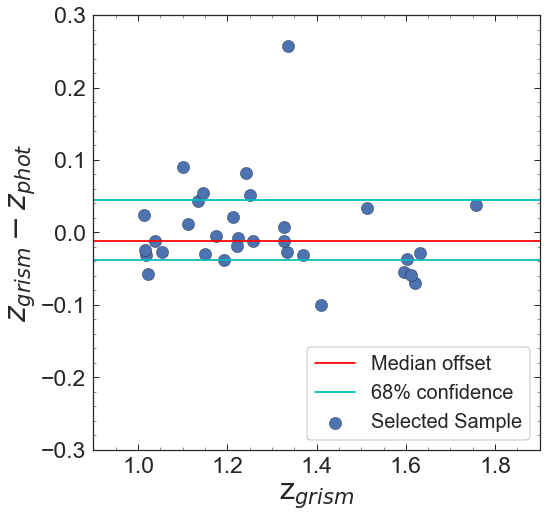

In [12]:
### PLOT 
%matplotlib inline

zs= list(galDB['hi_res_specz'])

plt.figure(figsize=[8,8])
# plt.plot(zs, list(res),'o')
plt.scatter(zs,list(res),marker='o', s=150,edgecolors='k',label = 'Selected Sample')
# plt.scatter(rejDB['hi_res_specz'][rejDB.IN_SAMP == 'out'],rejres,marker='o',s=150,
#             facecolors='none',edgecolors='k', linewidth=2, zorder=0, label = 'Rejected Sample')

plt.axhline(mres,color='r',label = 'Median offset')
plt.axhline(lres,color='c',label = '68% confidence')
plt.axhline(hres,color='c')
plt.xlim(.9,1.9)
plt.ylim(-.3,.3)
plt.ylabel('$z_{grism} - z_{phot}$',fontsize=30)
plt.xlabel('z$_{grism}$',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(loc=4,fontsize=20,frameon=True,edgecolor='k')
plt.minorticks_on()
plt.savefig('../plots/redshift_diff.pdf',bbox_inches = 'tight')

# SN vs mass and redshift

In [4]:
####DATA
rejDB = pd.read_pickle('../data/select_samp.pkl')

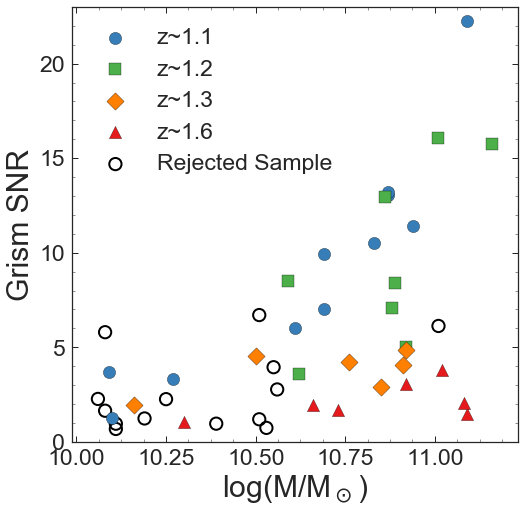

In [6]:
###PLOT
%matplotlib inline
#'#377eb8' '#4daf4a' '#ff7f00' '#e41a1c'
#'o','s','D','^'
plt.figure(figsize=[8,8])
plt.scatter(lzDB['lmass'],lzDB['SN'],marker='o', s=150,edgecolors='k', color='#377eb8', label = 'z~1.1')
plt.scatter(mzDB['lmass'],mzDB['SN'],marker='s', s=150,edgecolors='k',color='#4daf4a', label = 'z~1.2')
plt.scatter(hzDB['lmass'],hzDB['SN'],marker='D', s=150,edgecolors='k',color='#ff7f00', label = 'z~1.3')
plt.scatter(uhzDB['lmass'],uhzDB['SN'],marker='^', s=150,edgecolors='k',color='#e41a1c', label = 'z~1.6')
plt.scatter(rejDB['lmass'][rejDB.IN_SAMP == 'out'],rejDB['SN'][rejDB.IN_SAMP == 'out'],marker='o', 
            s=150,facecolors='none',edgecolors='k', linewidth=2, zorder=0, label = 'Rejected Sample')

# sea.distplot(galDB['lmass'],bins=12,kde=False)
plt.legend(loc=2,fontsize=23)
plt.xlabel('log(M/M$_\odot$)',fontsize=30)
plt.ylabel('Grism SNR',fontsize=30)
plt.ylim(0,23)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.savefig('../plots/sn_v_mass.pdf',bbox_inches = 'tight')

# Photo z - Grism z

In [108]:
#DATA

photz =np.array([1.13, 0.99, 1.23, 1.01, 1.2, 1.48, 1.09, 1.18, 1.09,
        1.27, 1.26, 1.23, 1.18, 1.66, 1.08, 1.05, 1.08, 1.36,
        1.16, 1.65, 1.19, 1.24, 1.51, 1.34, 1.72, 1.64, 1.69,
        1.04, 1.67, 1.08, 1.05, 1.32, 1.4 , 1.1, 1.14])

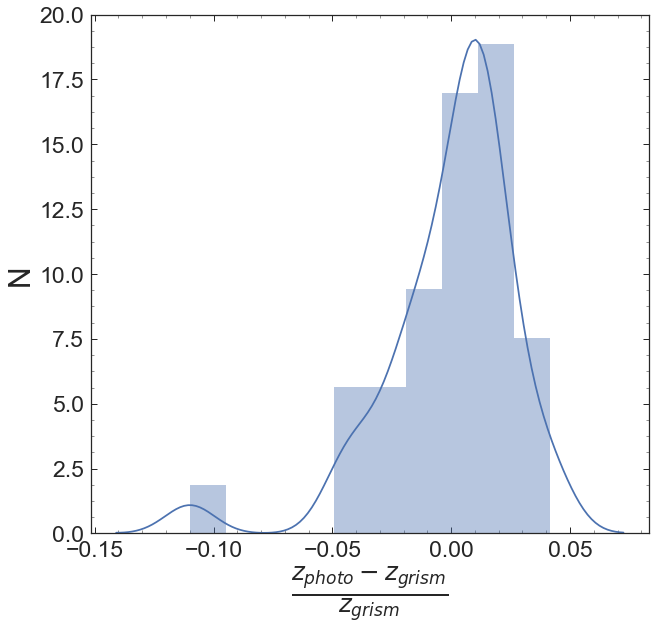

In [110]:
#PLOT
%matplotlib inline

plt.figure(figsize=[10,10])
sea.distplot((photz - galDB['hi_res_specz'])/(1+galDB['hi_res_specz']) ,kde=True,bins=10)
plt.legend(loc=2,fontsize=23)
plt.xlabel('$\\frac{z_{photo}-z_{grism}}{z_{grism}}$',fontsize=35)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.show()
plt.savefig('../plots/photo_vs_grism_z.pdf',bbox_inches = 'tight')

# UVJ plot

In [15]:
###DATA 
uvjDB = pd.read_pickle('../data/uvj_db.pkl')
uvjSDB = pd.read_pickle('../data/select_samp.pkl')
# uvjSDB = uvjDB[uvjDB['IN_SAMP'] == True]
# uvjSDB = uvjSDB.query('ra != 189.236333 and ra != 189.284502')

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


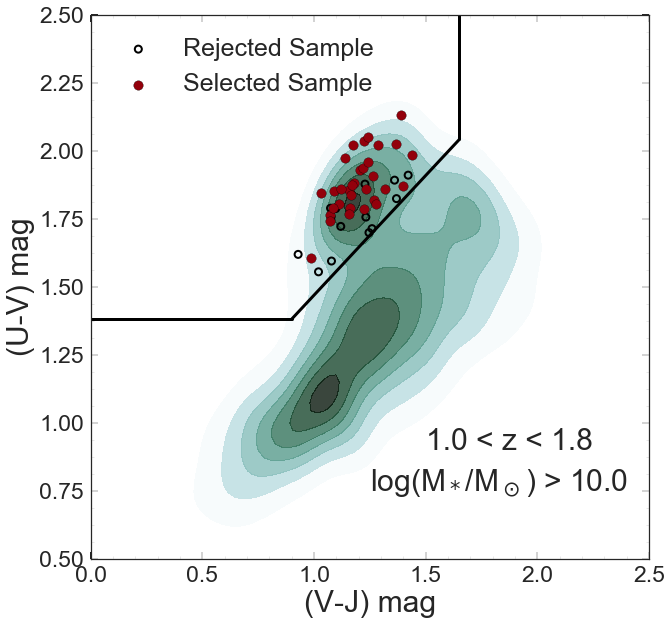

In [16]:
###PLOTS
%matplotlib inline

plt.figure(figsize=[10,10])
sea.kdeplot(uvjDB['(V-J)'],uvjDB['(U-V)'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)
plt.scatter(uvjSDB['(V-J)'][uvjSDB.IN_SAMP == 'out'].values,uvjSDB['(U-V)'][uvjSDB.IN_SAMP == 'out'].values,facecolor='none',
            edgecolors='k',linewidth=2, label = 'Rejected Sample')
plt.scatter(uvjSDB['(V-J)'][uvjSDB.IN_SAMP == 'in'],uvjSDB['(U-V)'][uvjSDB.IN_SAMP == 'in'],edgecolors='k',color='#93000B',s=90, label = 'Selected Sample')

plt.plot([0,.9],[1.382,1.382],'k',lw=.9,linewidth=3)
plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9,linewidth=3)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9,linewidth=3)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2,fontsize=25)
plt.text(1.5,0.90,'1.0 < z < 1.8', fontsize = 30)
plt.text(1.25,0.75,'log(M$_*$/M$_\odot$) > 10.0', fontsize = 30)
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.minorticks_on()
plt.savefig('../plots/uvj_kde_plot_5-16.pdf',bbox_inches = 'tight')


# Example Spectra and Best Fit

In [3]:
###DATA
spec = Gen_spec(galDB['gids'][61], galDB['hi_res_specz'][61],delayed=True,maxwv=11400)
bftau = Median_model(galDB['gids'][61], galDB['hi_res_specz'][61], galDB['Z_lwa'][61], galDB['t_lwa'][61], tau)
spec.Sim_spec(galDB['Z_lwa'][61],galDB['t_lwa'][61],bftau)
print bftau

No TEAL-based tasks available for this package!
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


8.0


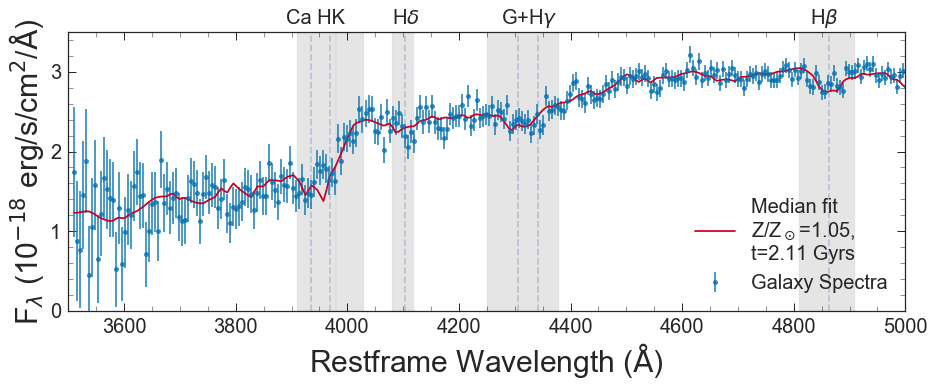

In [7]:
###PLOT
%matplotlib inline

sea.set_style( {"xtick.major.size": 8, "ytick.major.size": 8,
                "xtick.minor.size": 5, "ytick.minor.size": 5})
plt.figure(figsize=(15,6))
plt.errorbar(spec.gal_wv_rf,spec.gal_fl*1E18,spec.gal_er*1E18,fmt='o',color='#0571b0', alpha = .8,ms=5,label = 'Galaxy Spectra')
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020',
         label='Median fit\nZ/Z$_\odot$=%s,\nt=%s Gyrs' % (np.round(galDB['Zx_lwa'][61]/0.019,2),
                                                           np.round(galDB['tx_lwa'][61],2)))
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.text(3890,3.6,'Ca HK',fontsize=20)
plt.text(4080,3.6,'H$\delta$',fontsize=20)
plt.text(4275,3.6,'G+H$\gamma$',fontsize=20)
plt.text(4830,3.6,'H$\\beta$',fontsize=20)
# plt.text(5160,5.6,'Mgb',fontsize=20)
plt.xlim(3500,5000)
plt.ylim(0,3.5)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()
plt.savefig('../plots/n21156_spec_2-1.pdf',bbox_inches = 'tight')


#Grizli Example

In [18]:
###DATA
spec = Gen_sim(galDB['gids'][61], galDB['hi_res_specz'][61],galDB['Z_lwa'][61],galDB['t_lwa'][61],8.48,maxwv=11400)
spec.Sim_spec(galDB['Z_lwa'][61],galDB['t_lwa'][61],8.48)
spec.RM_sim_spec_cont()
spec.Perturb_both()
print galDB['Z_lwa'][61],galDB['t_lwa'][61]
wv,fl = np.load('../../../fsps_models_for_fit/fsps_spec/m0.02_a2.2_dt8.48_spec.npy')

../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
0.02 2.2


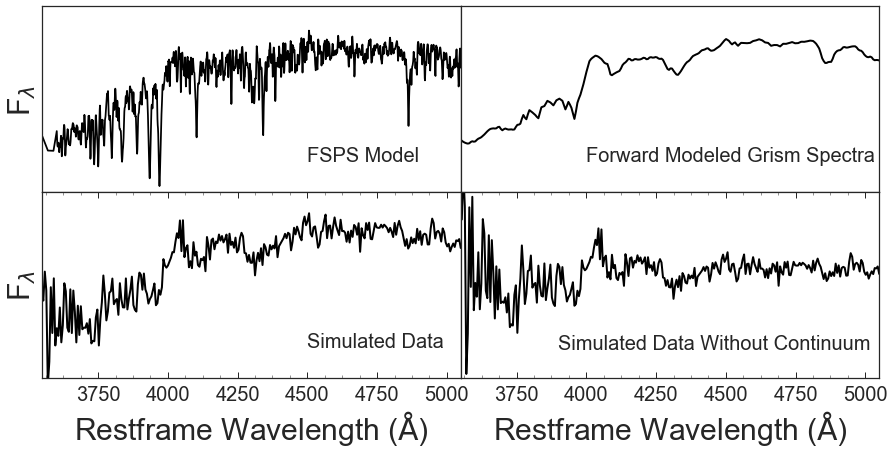

In [22]:
###PLOT###PLOT
%matplotlib inline

gs = gridspec.GridSpec(2,2,wspace=0,hspace=0)

plt.figure(figsize=(15,8))
plt.subplot(gs[0,0])
plt.plot(wv,fl*3E4, color='k')
plt.xlim(3550,5050)
plt.ylim(0.5,3.5)
plt.xticks([])
plt.yticks([])
plt.ylabel('F$_\lambda$',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4500,1,'FSPS Model',fontsize=20)
plt.minorticks_on()

plt.subplot(gs[0,1])
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='k', linewidth=2)
plt.xlim(3550,5050)
plt.ylim(0.5,3.5)
plt.xticks([])
plt.yticks([])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4000,1,'Forward Modeled Grism Spectra',fontsize=20)
plt.minorticks_on()

plt.subplot(gs[1,0])
plt.plot(spec.gal_wv_rf,spec.flx_err*1E18, color='k',linewidth=2)
plt.xlim(3550,5050)
plt.ylim(0.5,3.5)
plt.yticks([])
plt.ylabel('F$_\lambda$',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4500,1,'Simulated Data',fontsize=20)
plt.minorticks_on()

plt.subplot(gs[1,1])
plt.plot(spec.gal_wv_rf,spec.nc_flx_err, color='k', linewidth=2)
plt.xlim(3550,5050)
plt.ylim(0.25,1.5)
plt.yticks([])
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(3900,.44,'Simulated Data Without Continuum',fontsize=20)
plt.minorticks_on()

# plt.show()
plt.savefig('../plots/ex_gr_sim_12-6.pdf',bbox_inches = 'tight')
# plt.close()

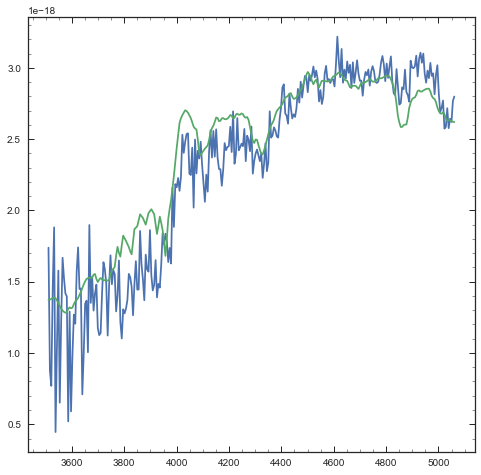

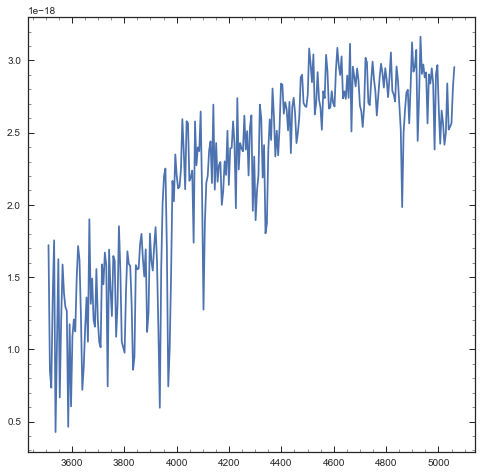

In [28]:
ifl=interp1d(wv,fl)(spec.gal_wv_rf)
plt.figure(figsize=[8,8])
plt.plot(spec.gal_wv_rf,spec.gal_fl)
plt.plot(spec.gal_wv_rf,spec.fl)
# plt.plot(spec.gal_wv_rf,ifl*3E-14)

plt.figure(figsize=[8,8])
plt.plot(spec.gal_wv_rf,spec.gal_fl/spec.fl*ifl*3E-14)


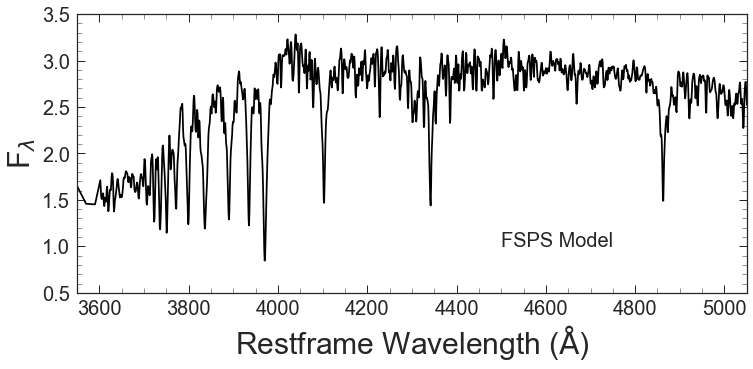

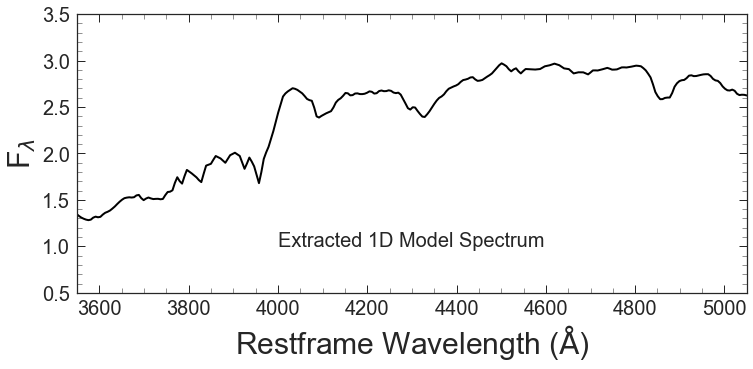

In [61]:
###PLOT###PLOT
%matplotlib inline


plt.figure(figsize=(12,6))
plt.plot(wv,fl*1.9E4, color='k')
plt.xlim(3550,5050)
plt.ylim(0.5,3.5)
plt.ylabel('F$_\lambda$',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4500,1,'FSPS Model',fontsize=20)
plt.minorticks_on()
plt.savefig('../plots/ex_fsps_2-6.png',bbox_inches = 'tight')


plt.figure(figsize=(12,6))
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='k', linewidth=2)
plt.xlim(3550,5050)
plt.ylim(0.5,3.5)
plt.ylabel('F$_\lambda$',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.text(4000,1,'Extracted 1D Model Spectrum',fontsize=20)
plt.minorticks_on()
plt.savefig('../plots/ex_grism_2-6.png',bbox_inches = 'tight')




In [31]:
img = fits.open('../../../Clear_data/gal_flts/n21156_flt.fits')

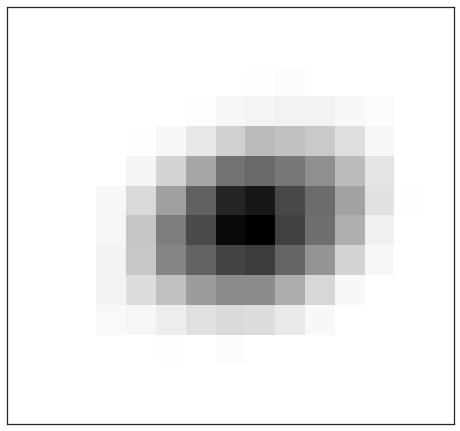

In [58]:

plt.figure(figsize=[8,8])
plt.imshow(np.arcsinh(img['SCI'].data[449:463,449:464]))
plt.xticks([])
plt.yticks([])
plt.savefig('../plots/ex_img_2-6.png',bbox_inches = 'tight')


#Simulation Example

In [19]:
###Data 
spec = Gen_sim(galDB['gids'][220],galDB['hi_res_specz'][220],0.019,2.0,8.0,maxwv=11400)
spec.Perturb_flux()
lines = [3934,3969,4102,4305,4341,4862,5176]
regions = [[3910, 3980],[3980, 4030],[4080, 4120],[4250, 4380],[4810, 4910],[5120, 5240]]
txlines = [3900,4070,4250,4830,5160]
text = ['Ca HK','H$\delta$','G+H$\gamma$','H$\\beta$','Mgb']

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


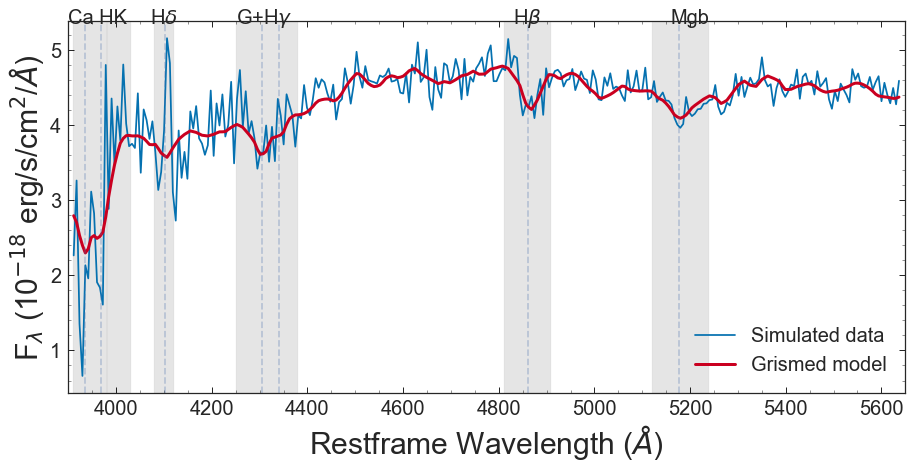

In [22]:
###Plot
%matplotlib inline
plt.figure(figsize=(15,8))
plt.plot(spec.gal_wv_rf,spec.flx_err*1E18, color='#0571b0',label='Simulated data')
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020',label='Grismed model',linewidth = 3)
[plt.axvline(U,linestyle='--', alpha=.3) for U in lines]   
[plt.axvspan(U[0], U[1], color='k', alpha=.1) for U in regions]   
[plt.text(txlines[U],5.35,text[U],fontsize=20) for U in range(len(txlines))]   
plt.xlim(3900,5650)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()
# plt.show()
# plt.savefig('../plots/simulated_data_10-26.pdf',bbox_inches = 'tight')
# plt.close()

# Example Posterior

In [59]:
###DATA
P = np.load('../chidat/n21156_dtau_tZ_pos_lwa.npy')
t,Pt = np.load('../chidat/n21156_dtau_t_pos_lwa.npy')
Z,PZ = np.load('../chidat/n21156_dtau_Z_pos_lwa.npy')
onesig,twosig = Likelihood_contours(age,metal,P)
levels = np.array([twosig,onesig])

P2,PZ2,Pt2 = Analyze_LH_lwa('../chidat/n21156_dtau_chidata.npy',galDB['hi_res_specz'][61],
                          metal,age,tau,age_conv='../data/light_weight_scaling_3.npy')

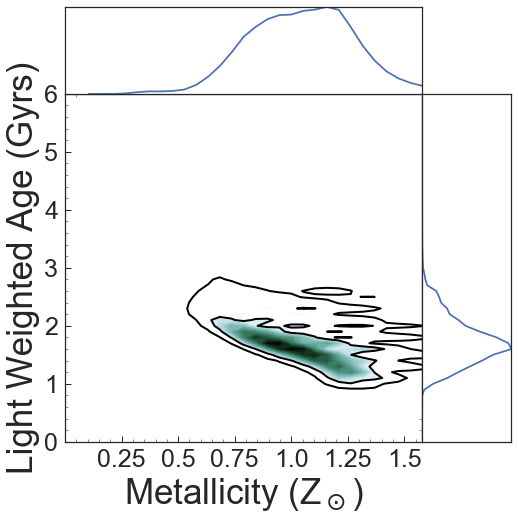

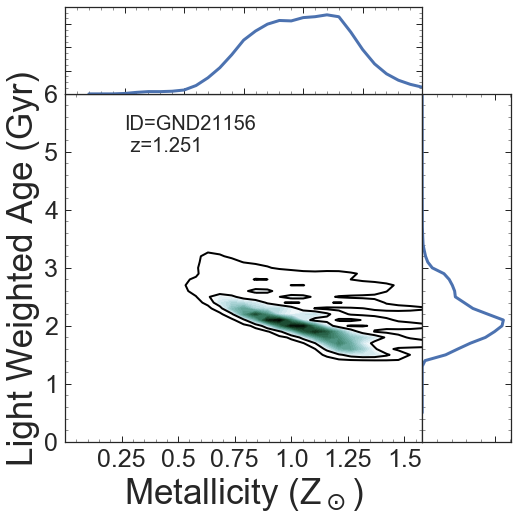

In [60]:
%matplotlib inline

###PLOT
gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
plt.figure(figsize=[8,8])

plt.subplot(gs[2])
plt.contour(M,A,P,levels,colors='k',linewidths=2)
plt.contourf(M,A,P,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyrs)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])

plt.subplot(gs[0])
plt.plot(Z,PZ)
plt.xticks([])
plt.yticks([])
plt.xlim(0,0.03)
plt.ylim(0,max(PZ))

plt.subplot(gs[3])
plt.plot(Pt,t)
plt.xticks([])
plt.yticks([])
plt.ylim(0,6)
plt.xlim(0,max(Pt))

plt.show()
# plt.savefig('../plots/n21156_lh_10-17.pdf',bbox_inches = 'tight')
plt.close()

gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
plt.figure(figsize=[8,8])

plt.subplot(gs[2])
plt.contour(M,A,P2,levels,colors='k',linewidths=2)
plt.contourf(M,A,P2,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=35)
plt.ylabel('Light Weighted Age (Gyr)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])
plt.text(.005,5,'ID=GND21156\n z=1.251', fontsize=20)

plt.subplot(gs[0])
plt.plot(Z,PZ2,linewidth=3)
plt.gca().tick_params(axis='y',labelleft='off')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.xlim(0,0.03)
plt.ylim(0,max(PZ2)*1.1)

plt.subplot(gs[3])
plt.plot(Pt2,t,linewidth=3)
plt.gca().tick_params(axis='y',labelleft='off')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.ylim(0,6)
plt.xlim(0,max(Pt2)*1.1)

# plt.show()
plt.savefig('../plots/n21156_lh_2-1.pdf',bbox_inches = 'tight')
# plt.close()

# Spectra and Photometry

In [4]:
###DATA 
phot_db = pd.read_pickle('../data/phot_db.pkl')
smpDB = pd.read_pickle('../data/sim_meas_phot.pkl')
rfDB = pd.read_pickle('../data/rfit_phot_db.pkl')
spec = Gen_spec('n21156', 1.251,maxwv=11450)
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)
if max(phot_db['n21156']*1E18 * Clam) > max(spec.gal_fl*1E18):
    ymax = max(phot_db['n21156']*1E18 * Clam)
else:
    ymax = max(spec.gal_fl*1E18)

No TEAL-based tasks available for this package!
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


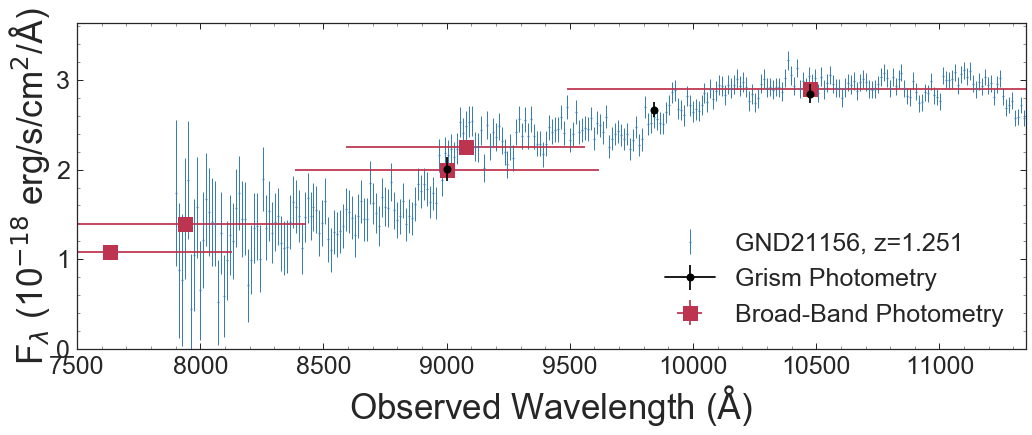

In [14]:
###PLOT
%matplotlib inline    

plt.figure(figsize=[17,6])
plt.errorbar(spec.gal_wv,spec.gal_fl * 1E18,spec.gal_er * 1E18,fmt='o',color = '#377eb8', ms=2,elinewidth=1,label = 'GND21156, z=1.251')

plt.errorbar(rfDB['f850wv'][61], rfDB['f850p'][61] * 1E18,
             rfDB['f850err'][61] * 1E18, marker='o',color='k',ms=8, label='Grism Photometry', zorder=3)
plt.errorbar(rfDB['f098wv'][61], rfDB['f098p'][61] * 1E18,
             rfDB['f098err'][61] * 1E18, marker='o',color='k',ms=8, zorder=3)
plt.errorbar(smpDB['f105-effwv'][61], 2.8466504099539296, 1.0545873462E-1, marker='o',color='k',ms=8, zorder=3)

plt.errorbar(phot_db['eff_wv'],phot_db['n21156'] * Clam *1E18 ,phot_db['n21156_err'] * Clam *1E18,
             phot_db['fwhm']/2 ,color='#BC344F',fmt='s',ms=15,label='Broad-Band Photometry', zorder=2)
plt.ylim(0,ymax*1.1)
plt.xlim(7500,11350)
plt.minorticks_on()
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Observed Wavelength ($ \\rm \AA$)',size=35)
plt.legend(loc=4,fontsize = 25)
plt.savefig('../plots/n21156_phot_spec.pdf',bbox_inches = 'tight')


In [21]:
print 1 - np.abs(((phot_db['n21156']*Clam)['n_F850LP']-smpDB['sim-f850'][61])/(phot_db['n21156']*Clam)['n_F850LP'])
print 1 - np.abs(((phot_db['n21156']*Clam)['n_F105W']-smpDB['sim-f105'][61])/(phot_db['n21156']*Clam)['n_F105W'])

print 1 - np.abs(((phot_db['s39170']*Clam)['s_F850LP']-smpDB['sim-f850'][220]* 1.07)/(phot_db['s39170']*Clam)['s_F850LP'])
print 1 - np.abs(((phot_db['s39170']*Clam)['s_F098M']-smpDB['sim-f098'][220]* 1.07)/(phot_db['s39170']*Clam)['s_F098M'])
print 1 - np.abs(((phot_db['s39170']*Clam)['s_F105W']-smpDB['sim-f105'][220]* 1.07)/(phot_db['s39170']*Clam)['s_F105W'])

0.992047502842
0.994443213068
0.999313722163
0.972285155461
0.993278747868


In [16]:
print (phot_db['s39170']*Clam)['s_F850LP']
print smpDB['sim-f850'][220]

4.31950686763e-18
4.03969275651e-18


In [16]:
###DATA 
# phot_db = pd.read_pickle('../data/phot_db.pkl').drop('s_F105W')
phot_db = pd.read_pickle('../data/phot_db.pkl')
rfDB = pd.read_pickle('../data/rfit_phot_db.pkl')
spec = Gen_spec('s39170', 1.022,maxwv=11300)
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)
if max(phot_db['s39170']*1E18 * Clam) > max(spec.gal_fl*1E18):
    ymax = max(phot_db['s39170']*1E18 * Clam)
else:
    ymax = max(spec.gal_fl*1E18)
    
phot_filt = Photometry(spec.gal_wv,spec.gal_fl,spec.gal_er,202)
phot_filt.Get_Sensitivity()

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


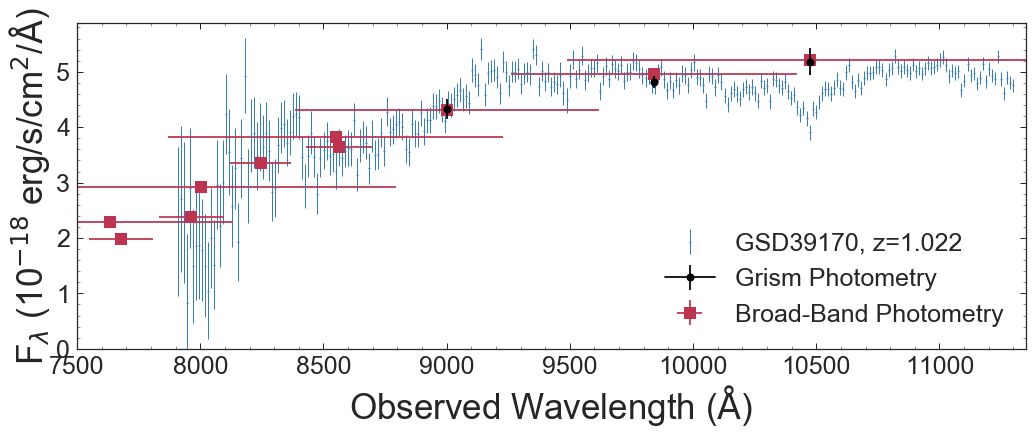

In [29]:
###PLOT
%matplotlib inline    

plt.figure(figsize=[17,6])
plt.errorbar(spec.gal_wv,spec.gal_fl * 1E18 *1.07,spec.gal_er * 1E18,fmt='o',color = '#377eb8', ms=2,elinewidth=1,label = 'GSD39170, z=1.022')

plt.errorbar(rfDB['f850wv'][220], rfDB['f850p'][220] * 1E18 * 1.07,
             rfDB['f850err'][220] * 1E18,  marker='o',color='k',ms=8, label='Grism Photometry',zorder=3)
plt.errorbar(rfDB['f098wv'][220], rfDB['f098p'][220] * 1E18 * 1.07,
             rfDB['f098err'][220] * 1E18,  marker='o',color='k',ms=8,zorder=3)
plt.errorbar(smpDB['f105-effwv'][220], 4.84370450776*1.07, 2.42883125156E-1,  marker='o',color='k',ms=8,zorder=3)

# plt.plot(phot_filt.sens_wv,phot_filt.trans*6)

plt.errorbar(phot_db['eff_wv'],phot_db['s39170'] * Clam *1E18 ,
             phot_db['s39170_err'] * Clam *1E18,
             phot_db['fwhm']/2 ,color='#BC344F',ms=12,fmt='s',zorder=2,label='Broad-Band Photometry')

plt.ylim(0,ymax*1.1)
# plt.xlim(8900,9100)
plt.xlim(7500,11350)
plt.minorticks_on()
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$ \\rm \AA$)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Observed Wavelength ($\\rm \AA$)',size=35)
plt.legend(loc=4,fontsize = 25)
plt.savefig('../plots/S39170_phot_spec.pdf',bbox_inches = 'tight')


In [54]:
phot_db['s39170'] * Clam *1E18

s_F606Wcand    -31.857304
s_F606W          0.913999
s_R              1.233447
s_Rc             1.290234
s_F775W          2.292199
s_I              3.831047
s_F814Wcand      2.915044
s_F850LP         4.319507
s_F850LPcand   -13.309904
s_F098M          4.957778
s_F105W          5.217834
s_F125W          5.276525
s_J              4.710720
s_tenisJ         5.352238
s_F140W          5.087417
s_H              3.660930
s_tenisK         3.916777
s_Ks             3.486547
s_IA624          0.981455
s_IA651          1.275914
s_IA679          1.565455
s_IA709          1.540021
s_IA738          1.862234
s_IA767          1.986706
s_IA797          2.375785
s_IA827          3.359957
s_IA856          3.648037
n_F606W        -31.857304
n_R            -25.625282
n_Rs           -23.403067
n_I            -17.109009
n_F775W        -18.503426
n_Z            -13.087955
n_F850LP       -13.309904
n_F105W         -9.825745
n_F125W         -7.001851
n_J             -6.902492
n_F140W         -5.637016
n_H         

In [78]:
###DATA 
# phot_db = pd.read_pickle('../data/phot_db.pkl').drop('s_F105W')
phot_db = pd.read_pickle('../data/phot_db.pkl')
spec = Gen_spec('s45972', 1.038,maxwv=11600)
Clam = 3E18 / phot_db['eff_wv'] **2 * 10**((-1.1)/2.5-29)
if max(phot_db['s45972']*1E18 * Clam) > max(spec.gal_fl*1E18):
    ymax = max(phot_db['s45972']*1E18 * Clam)
else:
    ymax = max(spec.gal_fl*1E18)

../data/galaxy_flts/s45972_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s45972_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s45972_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s45972_flt: save ../data/galaxy_flts/s45972_flt.detect_seg.fits, ../data/galaxy_flts/s45972_flt.detect.cat


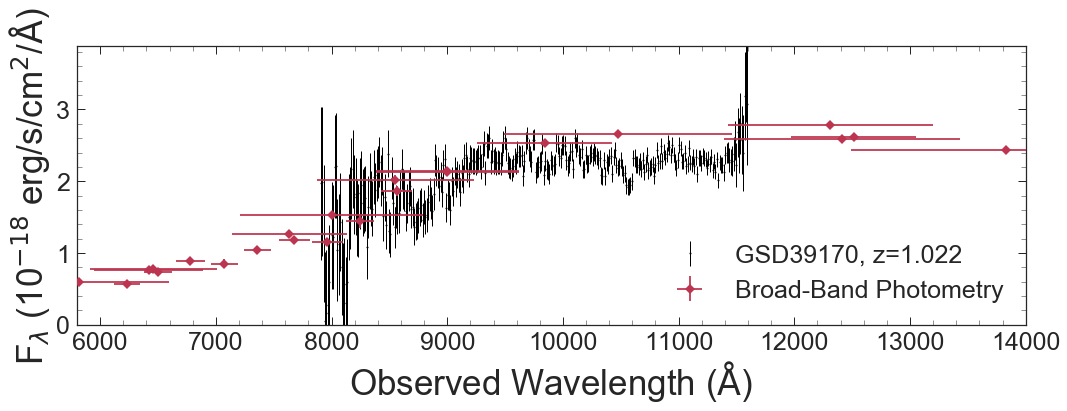

In [79]:
###PLOT
%matplotlib inline    

plt.figure(figsize=[17,6])
plt.errorbar(spec.gal_wv,spec.gal_fl * 1E18,spec.gal_er * 1E18 * 1.07,fmt='o',color = 'k', ms=2,elinewidth=1,label = 'GSD39170, z=1.022')

# plt.plot(smpDB['f850-effwv'][220], smpDB['sim-f850'][220] * 1E18 * 1.07,'d',color='#2B4CFF',ms=15)
# plt.plot(smpDB['f098-effwv'][220], smpDB['sim-f098'][220] * 1E18 * 1.07,'d',color='#2B4CFF',ms=15)
# plt.plot(smpDB['f105-effwv'][220], smpDB['sim-f105'][220] * 1E18 * 1.07,'d',color='#2B4CFF',ms=15)

plt.errorbar(phot_db['eff_wv'],phot_db['s45972'] * Clam *1E18 ,phot_db['s45972_err'] * Clam *1E18,
             phot_db['fwhm']/2 ,color='#BC344F',fmt='D',zorder=5,label='Broad-Band Photometry')
plt.ylim(0,ymax*1.1)
plt.xlim(5800,14000)
plt.minorticks_on()
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$ \\rm \AA$)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Observed Wavelength ($\\rm \AA$)',size=35)
plt.legend(loc=4,fontsize = 25)
plt.gcf().subplots_adjust(bottom=0.235)
# plt.savefig('../plots/S39170_phot_spec.pdf',bbox_inches = 'tight')
# plt.show()
# plt.close()

# redshift model compare

In [4]:
###DATA
spec1 = Gen_spec('s39170', 1.08,maxwv=11450)
spec2 = Gen_spec('s39170', 1.23,maxwv=11450)
spec3 = Gen_spec('s39170', 1.375,maxwv=11450)
spec6 = Gen_spec('s39170', 1.625,maxwv=11450)
spec1.Sim_spec(galDB['Z_lwa'][220],galDB['t_lwa'][220],8.48)
spec2.Sim_spec(galDB['Z_lwa'][220],galDB['t_lwa'][220],8.48)
spec3.Sim_spec(galDB['Z_lwa'][220],galDB['t_lwa'][220],8.48)
spec6.Sim_spec(galDB['Z_lwa'][220],galDB['t_lwa'][220],8.48)



No TEAL-based tasks available for this package!
../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat
../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../dat

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


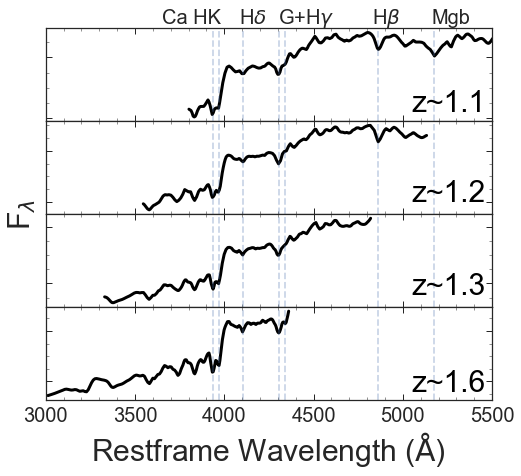

In [48]:
###PLOT###PLOT
%matplotlib inline

gs = gridspec.GridSpec(4,1,wspace=0,hspace=0)

plt.figure(figsize=(8,8))
plt.subplot(gs[0])
plt.plot(spec1.gal_wv_rf,spec1.fl*1E18, color='k', linewidth=3)
plt.xlim(3000,5500)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.text(3650,5.1,'Ca HK',fontsize=20)
plt.text(4080,5.1,'H$\delta$',fontsize=20)
plt.text(4300,5.1,'G+H$\gamma$',fontsize=20)
plt.text(4830,5.1,'H$\\beta$',fontsize=20)
plt.text(5160,5.1,'Mgb',fontsize=20)
plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelleft='off')
txt = plt.text(5050,2.2,'z~1.1', fontsize=30, color='k')
plt.minorticks_on()

plt.subplot(gs[1])
plt.plot(spec2.gal_wv_rf,spec2.fl*1E18, color='k', linewidth=3)
plt.xlim(3000,5500)
plt.ylabel('F$_\lambda$',size=30, position=(3000,0))
plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelleft='off')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
txt = plt.text(5050,2,'z~1.2', fontsize=30, color='k')
plt.minorticks_on()

plt.subplot(gs[2])
plt.plot(spec3.gal_wv_rf,spec3.fl*1E18, color='k', linewidth=3)
plt.xlim(3000,5500)
plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelleft='off')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
txt = plt.text(5050,2,'z~1.3', fontsize=30, color='k')
plt.minorticks_on()

plt.subplot(gs[3])
plt.plot(spec6.gal_wv_rf,spec6.fl*1E18, color='k',linewidth=3)
plt.xlim(3000,5500)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
txt = plt.text(5050,2,'z~1.6', fontsize=30, color='k')
# txt.set_path_effects([PathEffects.withStroke(linewidth=4,foreground='k')])
plt.minorticks_on()
plt.gca().tick_params(axis='y',labelleft='off')
plt.savefig('../plots/spec_groups_diff_2-7.pdf',bbox_inches = 'tight')


In [55]:
(1.45+1.8)/2

1.625

# Age Vs Redshift - 3 feat groups

In [7]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_3.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

def Gen_grid_dust(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_dust.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [8]:
"""DATA"""
rzoo = importr('zoo')

age_range = np.arange(0,3,0.05)

gmtlDB = galDB.query('ids != 14713 and ids != 38126 and ids != 40597')
ferrdb = pd.read_pickle('../data/Q_ferreras.pkl')

Pl_grid = Gen_grid(lzDB,'t')
Pm_grid = Gen_grid(mzDB,'t')
Ph_grid = Gen_grid(hzDB,'t')
Puh_grid = Gen_grid(uhzDB,'t')

Pl_grid_d = Gen_grid_dust(lzDB,'t')
Pm_grid_d = Gen_grid_dust(mzDB,'t')
Ph_grid_d = Gen_grid_dust(hzDB,'t')
Puh_grid_d = Gen_grid_dust(uhzDB,'t')

Pl,Px = Iterative_stacking(Pl_grid,age)
Pm,Px = Iterative_stacking(Pm_grid,age)
Ph,Px = Iterative_stacking(Ph_grid,age)
Puh,Px = Iterative_stacking(Puh_grid,age)

Pl_d,Px = Iterative_stacking(Pl_grid_d,age)
Pm_d,Px = Iterative_stacking(Pm_grid_d,age)
Ph_d,Px = Iterative_stacking(Ph_grid_d,age)
Puh_d,Px = Iterative_stacking(Puh_grid_d,age)

lmed,ller,lher=Median_w_Error_cont(Pl,Px)
mmed,mler,mher=Median_w_Error_cont(Pm,Px)
hmed,hler,hher=Median_w_Error_cont(Ph,Px)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,Px)

lmed_d,ller_d,lher_d=Median_w_Error_cont(Pl_d,Px)
mmed_d,mler_d,mher_d=Median_w_Error_cont(Pm_d,Px)
hmed_d,hler_d,hher_d=Median_w_Error_cont(Ph_d,Px)
uhmed_d,uhler_d,uhher_d=Median_w_Error_cont(Puh_d,Px)

lt=np.array(lzDB['tx_lwa'])
mt=np.array(mzDB['tx_lwa'])
ht=np.array(hzDB['tx_lwa'])
uht=np.array(uhzDB['tx_lwa'])
gmtlt=np.array(gmtlDB['tx_lwa'])

fumx,fumy=Readfile('../data/fumagalli_fig14.dat',0)
d,fverr=Readfile('../data/fumagalli_fig14_verr.dat',0)
fherr,d=Readfile('../data/fumagalli_fig14_herr.dat',0)

verr=np.zeros(len(fverr))
herr=np.zeros(len(fherr))
for i in range(len(verr)):
    verr[i]=np.abs(fverr[i]-fumy[i])
    herr[i]=np.abs(fherr[i]-fumx[i])
    
gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../data/millennium2.txt',
                                                                            skiprows=31,delimiter=',').T
mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
                        'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
                       'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})
IDW =z_g.argsort()
eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """


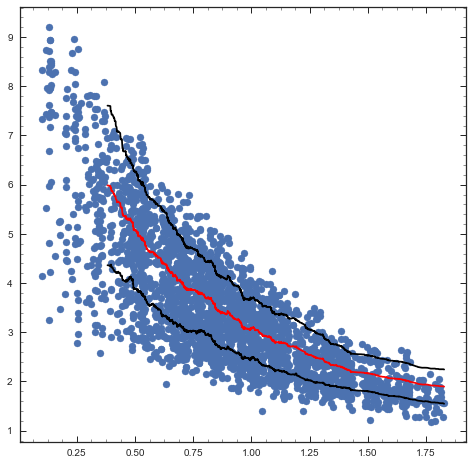

In [23]:
plt.figure(figsize=[8,8])
plt.scatter(z_g[IDW],rbWage)
plt.plot(z_g[IDW],rmean,'r')
plt.plot(z_g[IDW],np.array(rstd) + np.array(rmean),'k')
plt.plot(z_g[IDW],np.array(rmean) - np.array(rstd),'k')

In [17]:
print lmed,ller,lher
print mmed,mler,mher
print hmed,hler,hher
print uhmed,uhler,uhher

3.45390781563 1.03607214429 0.90380761523
2.26352705411 0.749498997996 0.716432865731
2.72645290581 0.661322645291 0.705410821643
1.86673346693 0.683366733467 0.551102204409


/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in rbind.zoo(...) : indexes overlap

  warnings.warn(x, RRuntimeWarning)
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: There were 11 warnings (use warnings() to see them)
  warnings.warn(x, RRuntimeWarning)
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in add
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: in

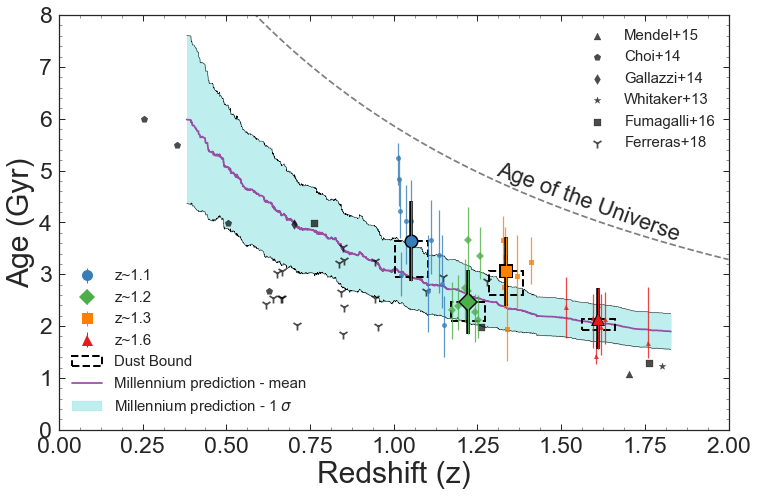

In [10]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

ax1=plt.scatter(fumx[9],fumy[9],color = 'k',marker='^',zorder=2,alpha=0.7)         
ax2=plt.scatter(fumx[10:14],fumy[10:14],color = 'k',marker='p',zorder=2,alpha=0.7) 
ax3=plt.scatter(fumx[14],fumy[14],color = 'k',marker='d',zorder=2,alpha=0.7)       
ax4=plt.scatter(fumx[15],fumy[15],color = 'k',marker='*',zorder=2,alpha=0.7)       
# ax5=plt.errorbar(fumx[6:9],fumy[6:9],xerr=herr[6:9],yerr=verr[6:9]
#              ,color='k',zorder=2,fmt='o',alpha=.5,ms=1)
# ax6=plt.errorbar(ferrdb['z'],ferrdb['age'].values,ferrdb['age_err']
#              ,color='k',zorder=2,fmt='s',alpha=.5,ms=3)
ax5=plt.scatter(fumx[6:9],fumy[6:9],color='k',zorder=2,marker='s',alpha=0.7)
ax6=plt.scatter(ferrdb['z'],ferrdb['age'].values,color='k',zorder=2,marker='1',s=100,alpha=0.7)

###allpoints
plt.errorbar(lzDB['hi_res_specz'],lt,yerr=[lzDB['tx_-_sig_lwa'],lzDB['tx_+_sig_lwa']],
             color='#377eb8',elinewidth=1.25,alpha=.8,ms=5,fmt='o',zorder=3)
plt.errorbar(mzDB['hi_res_specz'],mt,yerr=[mzDB['tx_-_sig_lwa'],mzDB['tx_+_sig_lwa']],
             color='#4daf4a',elinewidth=1.25,alpha=.8,ms=5,fmt='D',zorder=3)
plt.errorbar(hzDB['hi_res_specz'],ht,yerr=[hzDB['tx_-_sig_lwa'],hzDB['tx_+_sig_lwa']],
             color='#ff7f00',elinewidth=1.25,alpha=.8,ms=5,fmt='s',zorder=3)
plt.errorbar(uhzDB['hi_res_specz'],uht,yerr=[uhzDB['tx_-_sig_lwa'],uhzDB['tx_+_sig_lwa']],
             color='#e41a1c',elinewidth=1.25,alpha=.8,ms=5,fmt='^',zorder=3)

####edge
plt.errorbar(np.median(lzDB['hi_res_specz']),lmed,yerr=[[ller,lher]], color='k',elinewidth=3.5,ms=14,fmt='o',zorder=4)
plt.errorbar(np.median(mzDB['hi_res_specz']),mmed,yerr=[[mler,mher]], color='k',elinewidth=3.5,ms=14,fmt='D',zorder=4)
plt.errorbar(np.median(hzDB['hi_res_specz']),hmed,yerr=[[hler,hher]], color='k',elinewidth=3.5,ms=14,fmt='s',zorder=4)
plt.errorbar(np.median(uhzDB['hi_res_specz']),uhmed,yerr=[[uhler,uhher]], color='k',elinewidth=3.5,ms=14,fmt='^',zorder=4)

####face
plt.errorbar(np.median(lzDB['hi_res_specz']),lmed,yerr=[[ller,lher]], color ='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1',zorder=5)
plt.errorbar(np.median(mzDB['hi_res_specz']),mmed,yerr=[[mler,mher]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2',zorder=5)
plt.errorbar(np.median(hzDB['hi_res_specz']),hmed,yerr=[[hler,hher]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3',zorder=5)
plt.errorbar(np.median(uhzDB['hi_res_specz']),uhmed,yerr=[[uhler,uhher]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6',zorder=5)

#### millenium
plt.plot(z_g[IDW],rmean,color = '#984ea3',zorder=1,label = 'Millennium prediction - mean')
plt.plot(z_g[IDW],np.array(rstd) + np.array(rmean),'k',linewidth = .5,zorder=1)
plt.plot(z_g[IDW],np.array(rmean) - np.array(rstd),'k',linewidth = .5,zorder=1)
plt.fill_between(z_g[IDW],np.array(rmean) - np.array(rstd),np.array(rstd) + np.array(rmean),
                color='c',alpha = .25,label = 'Millennium prediction - 1 $\sigma$',zorder=1)

currentAxis.add_patch(Rectangle((np.median(lzDB['hi_res_specz'])-0.05, lmed_d)
                                ,0.1,lmed-lmed_d,fill=False ,edgecolor='k',
                                label='Dust Bound',zorder=2,linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(mzDB['hi_res_specz'])-0.05, mmed_d)
                                ,0.1,mmed-mmed_d,fill=False ,edgecolor='k',
                                zorder=2,linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(hzDB['hi_res_specz'])-0.05, hmed_d)
                                ,0.1,hmed-hmed_d,fill=False ,edgecolor='k',
                                zorder=2,linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(uhzDB['hi_res_specz'])-0.05, uhmed_d)
                                ,0.1,uhmed-uhmed_d,fill=False ,edgecolor='k',
                                zorder=2,linewidth=2,linestyle='dashed'))
handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([3,4,5,6,1,0,2])

plt.axis([0.,2.0,0,8])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Age (Gyr)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.text(1.3,4.9,'Age of the Universe',rotation=-20,fontsize=22)
plt.gcf().subplots_adjust(bottom=0.16)
l1= plt.legend([ax1,ax2,ax3,ax4,ax5,ax6],['Mendel+15','Choi+14','Gallazzi+14','Whitaker+13','Fumagalli+16','Ferreras+18'],
              fontsize=15)
plt.legend(handles[IDX], labels[IDX],loc = 3, fontsize=15)
currentAxis.add_artist(l1)
plt.savefig('../plots/agevz_featgroup_all_dt_2-27.pdf',bbox_inches = 'tight')




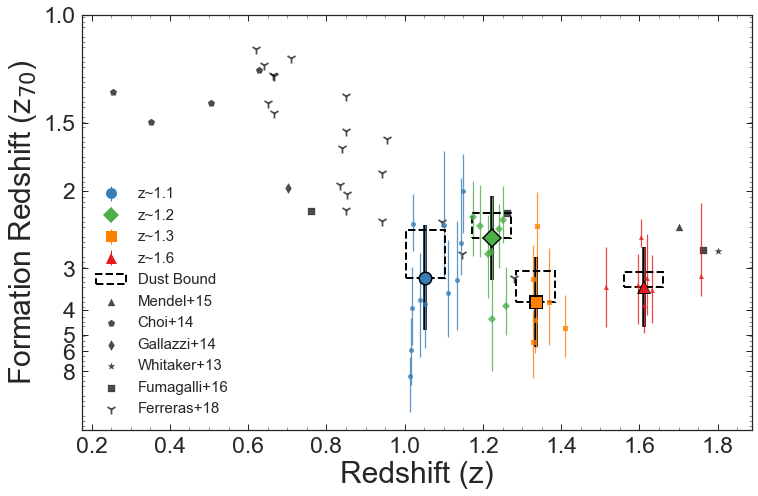

In [11]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
# plt.plot(z,ages,'k--',alpha=.5)

plt.scatter(fumx[9], Oldest_galaxy(fumx[9]) - fumy[9],color = 'k',marker='^',label='Mendel+15',alpha=0.7)
plt.scatter(fumx[10:14],Oldest_galaxy(fumx[10:14]) - fumy[10:14],color = 'k',marker='p',label='Choi+14',alpha=0.7)
plt.scatter(fumx[14],Oldest_galaxy(fumx[14]) - fumy[14],color = 'k',marker='d',label='Gallazzi+14',alpha=0.7)
plt.scatter(fumx[15],Oldest_galaxy(fumx[15]) - fumy[15],color = 'k',marker='*',label='Whitaker+13',alpha=0.7)
plt.scatter(fumx[6:9],Oldest_galaxy(fumx[6:9]) - fumy[6:9],color='k',zorder=2,marker='s',label='Fumagalli+16',alpha=0.7)
plt.scatter(ferrdb['z'],Oldest_galaxy(ferrdb['z'].values) - ferrdb['age'].values,color='k',zorder=2,marker='1',s=100,label='Ferreras+18',alpha=0.7)

plt.errorbar(lzDB['hi_res_specz'], Oldest_galaxy(lzDB['hi_res_specz']) - lt,
             yerr=[lzDB['tx_-_sig_lwa'],lzDB['tx_+_sig_lwa']],color='#377eb8',elinewidth=1.25,alpha=.8,ms=5,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],Oldest_galaxy(mzDB['hi_res_specz']) - mt,
             yerr=[mzDB['tx_-_sig_lwa'],mzDB['tx_+_sig_lwa']],color='#4daf4a',elinewidth=1.25,alpha=.8,ms=5,fmt='D')
plt.errorbar(hzDB['hi_res_specz'],Oldest_galaxy(hzDB['hi_res_specz']) - ht,
             yerr=[hzDB['tx_-_sig_lwa'],hzDB['tx_+_sig_lwa']],color='#ff7f00',elinewidth=1.25,alpha=.8,ms=5,fmt='s')
plt.errorbar(uhzDB['hi_res_specz'],Oldest_galaxy(uhzDB['hi_res_specz']) - uht,
             yerr=[uhzDB['tx_-_sig_lwa'],uhzDB['tx_+_sig_lwa']],color='#e41a1c',elinewidth=1.25,alpha=.8,ms=5,fmt='^')

plt.errorbar(np.median(lzDB['hi_res_specz']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='k',fmt='o',elinewidth=3.5,ms=14)
plt.errorbar(np.median(mzDB['hi_res_specz']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='k',fmt='D',elinewidth=3.5,ms=14)
plt.errorbar(np.median(hzDB['hi_res_specz']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='k',fmt='s',elinewidth=3.5,ms=14)
plt.errorbar(np.median(uhzDB['hi_res_specz']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='k',fmt='^',elinewidth=3.5,ms=14)

plt.errorbar(np.median(lzDB['hi_res_specz']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['hi_res_specz']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['hi_res_specz']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['hi_res_specz']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6')

currentAxis.add_patch(Rectangle((np.median(lzDB['hi_res_specz'])-0.05, 
                                 Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed)
                                ,0.1,lmed-lmed_d,fill=False ,edgecolor='k', zorder=2,
                                label='Dust Bound',linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(mzDB['hi_res_specz'])-0.05, 
                                 Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed)
                                ,0.1,mmed-mmed_d,fill=False ,edgecolor='k',zorder=2,linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(hzDB['hi_res_specz'])-0.05,
                                 Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed)
                                ,0.1,hmed-hmed_d,fill=False ,edgecolor='k',zorder=2,linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(uhzDB['hi_res_specz'])-0.05,
                                 Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed)
                                ,0.1,uhmed-uhmed_d,fill=False ,edgecolor='k', zorder=2,linewidth=2,linestyle='dashed'))

handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([7,8,9,10,0,1,2,3,4,5,6])

plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Formation Redshift (z$_{70}$)',size=30)
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,6,5,4,3,2,1.5,1.0])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(handles[IDX], labels[IDX],loc=3,fontsize=15)
plt.savefig('../plots/agevz_rshift_all_dt_2-27.pdf',bbox_inches = 'tight')

In [20]:
# [0.6389,0.76245,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,7,6,5,4,3,2,1.5,1.0]

print  Oldest_galaxy(0) * u.Gyr -Planck13.lookback_time(1)

5.86316614131 Gyr


# Mass Metallcity - feat group

In [12]:
"""DATA"""
gmtlDB = galDB.query('1.45 > hi_res_specz')
gmtlDB = gmtlDB.query('ids != 14713 and ids != 38126 and ids != 48631')

Pl_grid = Gen_grid(lzDB,'Z')
Pm_grid = Gen_grid(mzDB,'Z')
Ph_grid = Gen_grid(hzDB,'Z')
Puh_grid = Gen_grid(uhzDB,'Z')

Pl,Px = Iterative_stacking(Pl_grid,metal)
Pm,Px = Iterative_stacking(Pm_grid,metal)
Ph,Px = Iterative_stacking(Ph_grid,metal)
Puh,Px = Iterative_stacking(Puh_grid,metal)

lmed,ller,lher=Median_w_Error_cont(Pl,Px)
mmed,mler,mher=Median_w_Error_cont(Pm,Px)
hmed,hler,hher=Median_w_Error_cont(Ph,Px)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,Px)

Pl_grid_d = Gen_grid_dust(lzDB,'Z')
Pm_grid_d = Gen_grid_dust(mzDB,'Z')
Ph_grid_d = Gen_grid_dust(hzDB,'Z')
Puh_grid_d = Gen_grid_dust(uhzDB,'Z')

Pl_d,Px = Iterative_stacking(Pl_grid_d,metal)
Pm_d,Px = Iterative_stacking(Pm_grid_d,metal)
Ph_d,Px = Iterative_stacking(Ph_grid_d,metal)
Puh_d,Px = Iterative_stacking(Puh_grid_d,metal)

lmed_d,ller_d,lher_d=Median_w_Error_cont(Pl_d,Px)
mmed_d,mler_d,mher_d=Median_w_Error_cont(Pm_d,Px)
hmed_d,hler_d,hher_d=Median_w_Error_cont(Ph_d,Px)
uhmed_d,uhler_d,uhher_d=Median_w_Error_cont(Puh_d,Px)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx_lwa'])
mZ=np.array(mzDB['Zx_lwa'])
hZ=np.array(hzDB['Zx_lwa'])
uhZ=np.array(uhzDB['Zx_lwa'])
gmtlZ=np.array(gmtlDB['Zx_lwa'])

lerrs = gmtlDB['Zx_-_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
herrs = gmtlDB['Zx_+_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
errs = (gmtlDB['Zx_-_sig_lwa'] + gmtlDB['Zx_+_sig_lwa']/2) / (gmtlDB['Zx_lwa'] * np.log(10))
samp = np.arange(10,11.8,.01)
lfit,lfit_errs = Linear_fit(gmtlDB['lmass'],np.log10(gmtlZ/0.019),errs,samp)

gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../data/millennium2.txt',
                                                                            skiprows=31,delimiter=',').T
mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
                        'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
                       'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})
# IDW =z_g.argsort()
# eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
# rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
# rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

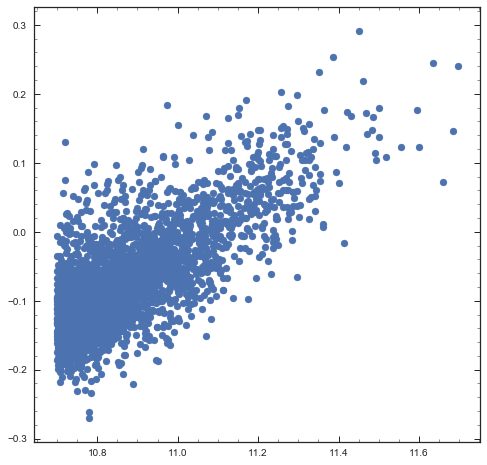

In [9]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.scatter(np.log10(smass*1E10),np.log10(metalsSMass / smass / .02))

In [70]:
print np.array([lmed,ller,lher])/0.019
print np.array([mmed,mler,mher])/0.019
print np.array([hmed,hler,hher])/0.019
print np.array([uhmed,uhler,uhher])/0.019

[ 0.99419892  0.43117815  0.3780192 ]
[ 0.94103997  0.4843371   0.40755195]
[ 1.02963822  0.29828077  0.32781352]
[ 1.16548887  0.62018774  0.3189537 ]


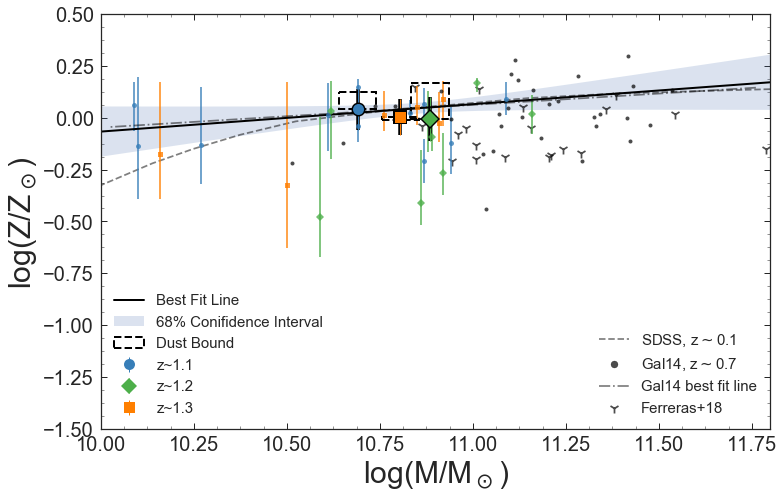

In [13]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.5,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.5,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.7,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.7)#,label='Gallazzi+14,z=0.7')
#####ferreras points
ferra = plt.scatter(np.log10(ferrdb['M']*1E11),ferrdb['Z/H'].values,color='k',zorder=2,marker='1',alpha=.7,s=100,label='Ferreras+18')
legend1 = plt.legend([sdss,galpts,galbf,ferra],
                     ['SDSS, z$\sim$0.1','Gal14, z$\sim$0.7','Gal14 best fit line','Ferreras+18'],
                     loc = 4,fontsize=15)
currentAxis.add_artist(legend1)
#####single galaxy points
plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_-_sig_lwa']/(lzDB['Zx_lwa'] * np.log(10)),
            lzDB['Zx_+_sig_lwa']/(lzDB['Zx_lwa'] * np.log(10))],color='#377eb8',alpha=.8,ms=5,fmt='o')
plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_-_sig_lwa']/(mzDB['Zx_lwa'] * np.log(10)),
            mzDB['Zx_+_sig_lwa']/(mzDB['Zx_lwa'] * np.log(10))],color='#4daf4a',alpha=.8,ms=5,fmt='D')
plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_-_sig_lwa']/(hzDB['Zx_lwa'] * np.log(10)),
            hzDB['Zx_+_sig_lwa']/(hzDB['Zx_lwa'] * np.log(10))],color='#ff7f00',alpha=.8,ms=5,fmt='s')

#### best fit line
plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')


#### edge
plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), 
             yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],color='k',ms=14,fmt='o',elinewidth=3.5)
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  
             yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],color='k',ms=14,fmt='D',elinewidth=3.5)
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  
             yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],color='k',ms=14,fmt='s',elinewidth=3.5)

#### face
plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],
            [lher/(lmed * np.log(10))]], color='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],
            [mher/(mmed * np.log(10))]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],
            [hher/(hmed * np.log(10))]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3')


currentAxis.add_patch(Rectangle((np.median(lzDB['lmass'])-0.05, np.log10(lmed_d/0.019))
                                ,0.1,np.log10((lmed/lmed_d)),fill=False ,edgecolor='k',
                                label='Dust Bound',zorder=2,linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(mzDB['lmass'])-0.05, np.log10(mmed_d/0.019))
                                ,0.1,np.log10((mmed/mmed_d)),fill=False ,edgecolor='k',
                                zorder=2,linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(hzDB['lmass'])-0.05, np.log10(hmed_d/0.019))
                                ,0.1,np.log10((hmed/hmed_d)),fill=False ,edgecolor='k',
                                zorder=2,linewidth=2,linestyle='dashed'))
# currentAxis.add_patch(Rectangle((np.median(uhzDB['lmass'])-0.05, np.log10(uhmed_d/0.019))
#                                 ,0.1,np.log10((uhmed/uhmed_d)),fill=False ,edgecolor='k',
#                                 zorder=2,linewidth=2,linestyle='dashed'))
handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([0,3,1,4,5,6])

plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()

plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(handles[IDX], labels[IDX],loc=3,fontsize=15)
plt.savefig('../plots/metalmass_featgroup_2-27.pdf',bbox_inches = 'tight')

In [61]:
print handles[1]

Rectangle(10.64,0.124136;0.1x-0.080215)


# 3 Stack best fits, Feat group

In [26]:
"""DATA"""
lzDB = galDB.query('hi_res_specz < 1.16')
lzDB = lzDB.query('ids != 48631')

mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

PZl_grid = Gen_grid(lzDB,'Z')
PZm_grid = Gen_grid(mzDB,'Z')
PZh_grid = Gen_grid(hzDB,'Z')
PZuh_grid = Gen_grid(uhzDB,'Z')

PTl_grid = Gen_grid(lzDB,'t')
PTm_grid = Gen_grid(mzDB,'t')
PTh_grid = Gen_grid(hzDB,'t')
PTuh_grid = Gen_grid(uhzDB,'t')

PZl,PZx = Iterative_stacking(PZl_grid,metal)
PZm,PZx = Iterative_stacking(PZm_grid,metal)
PZh,PZx = Iterative_stacking(PZh_grid,metal)
PZuh,PZx = Iterative_stacking(PZuh_grid,metal)

PTl,Ptx = Iterative_stacking(PTl_grid,age)
PTm,Ptx = Iterative_stacking(PTm_grid,age)
PTh,Ptx = Iterative_stacking(PTh_grid,age)
PTuh,Ptx = Iterative_stacking(PTuh_grid,age)

wPZl = Stack_posteriors(PZl_grid,metal)
wPZm = Stack_posteriors(PZm_grid,metal)
wPZh = Stack_posteriors(PZh_grid,metal)
wPZuh = Stack_posteriors(PZuh_grid,metal)

wPTl = Stack_posteriors(PTl_grid,age)
wPTm = Stack_posteriors(PTm_grid,age)
wPTh = Stack_posteriors(PTh_grid,age)
wPTuh = Stack_posteriors(PTuh_grid,age)

Zmedl, Zler, Zher = np.round(Median_w_Error(PZl,PZx),3)
Zmedm, Zler, Zher = np.round(Median_w_Error(PZm,PZx),3)
Zmedh, Zler, Zher = np.round(Median_w_Error(PZh,PZx),3)
Zmeduh, Zler, Zher = np.round(Median_w_Error(PZuh,PZx),3)
tmedl, tler, ther = np.round(Median_w_Error(PTl,Ptx),1)
tmedm, tler, ther = np.round(Median_w_Error(PTm,Ptx),1)
tmedh, tler, ther = np.round(Median_w_Error(PTh,Ptx),1)
tmeduh, tler, ther = np.round(Median_w_Error(PTuh,Ptx),1)

# print np.round(Median_w_Error(PZl,PZx),3)/.019
# print np.round(Median_w_Error(PZm,PZx),3)/.019
# print np.round(Median_w_Error(PZh,PZx),3)/.019
# print np.round(Median_w_Error(PZuh,PZx),3)/.019
# print np.round(Median_w_Error(PTl,Ptx),1)
# print np.round(Median_w_Error(PTm,Ptx),1)
# print np.round(Median_w_Error(PTh,Ptx),1)
# print np.round(Median_w_Error(PTuh,Ptx),1)

lzstack = Stack(lzDB['gids'].values,lzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3950,5200,1))
lzstack.Stack_normwmean()
lzstack.Stack_normwmean_model(Zmedl,tmedl,tau)#,bftau=8.0)

# mzstack = Stack(mzDB['gids'].values,mzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3650,4950,1))
# mzstack.Stack_normwmean()
# mzstack.Stack_normwmean_model(Zmedm,tmedm,tau,bftau=8.3)

# hzstack = Stack(hzDB['gids'].values,hzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3450,4550,1))
# hzstack.Stack_normwmean()
# hzstack.Stack_normwmean_model(Zmedh,tmedh,tau,bftau=8.48)

# uhzstack = Stack(uhzDB['gids'].values,uhzDB['hi_res_specz'].values,np.arange(3300,5300,10),np.arange(3400,4000,1))
# uhzstack.Stack_normwmean()
# uhzstack.Stack_normwmean_model(Zmeduh,tmeduh,tau,bftau=8.3)

../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat
../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../dat

In [19]:
"""PLOT"""
def Plot_stack(wv,fl,er,mwv,mfl,bfm,bfa,adist,A,mdist,M,wadist,wmdist,window=[],group='',group_win=[],save_plot=False,plot_name=''):
    
    gs = gridspec.GridSpec(2,2,hspace=0,wspace=0,width_ratios=[3,1])
    
    plt.figure(figsize=[15,7])
    plt.subplot(gs[0:,0])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#0571b0',fmt='o',ms = 4,elinewidth=2)
    plt.plot(mwv,mfl * 1000,color='#ca0020',label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfm/0.019,2),bfa),zorder = 5,linewidth = 2)
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.text(3900,window[3]+.05,'Ca HK',fontsize=15)
    plt.text(4080,window[3]+.05,'H$\delta$',fontsize=15)
    plt.text(4280,window[3]+.05,'G+H$\gamma$',fontsize=15)
    plt.text(group_win[0],group_win[1],group,fontsize=25,backgroundcolor=[.3,.3,.3],color='w')
    
    if window[1] > 4800:
        plt.text(4830,window[3]+.05,'H$\\beta$',fontsize=15)
    if window[1] > 5100:
        plt.text(5160,window[3]+.05,'Mgb',fontsize=15)
    
    plt.axis(window)
    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
        
    ax = plt.subplot(gs[0,1])
    plt.plot(age,wadist,label = 'P$^*$(t)',color='#377eb8',linewidth=3)
    plt.plot(A,adist,label = 'P(t)',color='#e41a1c',linewidth=3)
    plt.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    plt.xlim(min(age),max(age))
    plt.ylim(0,max(adist)*1.1)
    plt.xlabel('Age (Gyr)',size=20)
    plt.yticks([])
    plt.legend(fontsize=14)
    
    plt.subplot(gs[1,1])
    plt.plot(metal,wmdist,label = 'P$^*$(Z)',color='#377eb8',linewidth=3)
    plt.plot(M,mdist,label = 'P(Z)',color='#e41a1c',linewidth=3)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285],
           np.round(np.array([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285])/0.019, 2))    
    plt.xlabel('Metallicity (Z$_\odot$)',size=20)
    plt.xlim(min(metal),max(metal))
    plt.ylim(0,max(mdist)*1.1)
    plt.yticks([])
    plt.legend(fontsize=14)
    
    if save_plot == True:
        plt.savefig(plot_name,bbox_inches = 'tight')
    else:
        plt.show()
    plt.close()

            

In [27]:
print lzstack.bfmetal,lzstack.bfage, lzstack.bftau
# print mzstack.bfmetal,mzstack.bfage, mzstack.bftau
# print hzstack.bfmetal,hzstack.bfage, hzstack.bftau
# print uhzstack.bfmetal,uhzstack.bfage, uhzstack.bftau

0.021 3.6 0


In [47]:
print np.round(Median_w_Error(PZl,PZx),3)/0.019
print tmedl, tler, ther

[ 1.10526316  0.26315789  0.26315789]
3.6 0.6 0.6


In [28]:
mptl = np.round(Median_w_Error(PTl,Ptx),1)
mptm = np.round(Median_w_Error(PTm,Ptx),1)
mpth = np.round(Median_w_Error(PTh,Ptx),1)
mptuh = np.round(Median_w_Error(PTuh,Ptx),1)

mpzl = np.round(Median_w_Error(PZl,PZx),3)/.019
mpzm = np.round(Median_w_Error(PZm,PZx),3)/.019
mpzh = np.round(Median_w_Error(PZh,PZx),3)/.019
mpzuh = np.round(Median_w_Error(PZuh,PZx),3)/.019


mwptl = np.round(Median_w_Error(wPTl,age),1)
mwptm = np.round(Median_w_Error(wPTm,age),1)
mwpth = np.round(Median_w_Error(wPTh,age),1)
mwptuh = np.round(Median_w_Error(wPTuh,age),1)

mwpzl = np.round(Median_w_Error(wPZl,metal),3)/.019
mwpzm = np.round(Median_w_Error(wPZm,metal),3)/.019
mwpzh = np.round(Median_w_Error(wPZh,metal),3)/.019
mwpzuh = np.round(Median_w_Error(wPZuh,metal),3)/.019

In [29]:
print (np.abs((mptl - mwptl)/mwptl) + np.abs((mptm - mwptm)/mwptm) + np.abs((mpth - mwpth)/mwpth) + np.abs((mptuh - mwptuh)/mwptuh))/4

print (np.abs((mpzl - mwpzl)/mwpzl) + np.abs((mpzm - mwpzm)/mwpzm) + np.abs((mpzh - mwpzh)/mwpzh))/3

[ 0.01812039  0.1038961   0.11349206]
[ 0.05185185  0.38425926  0.33333333]


In [41]:
(.26+.21)/2

0.235

In [31]:
%matplotlib inline

Plot_stack(lzstack.wv,lzstack.fl,lzstack.er,lzstack.mwv,lzstack.mfl,0.021,3.6,PTl,Ptx,PZl,PZx,wPTl,wPZl,
           window=[3800,5300,.2,1.],group='z~1.1',group_win=[3850,0.9],save_plot=True,
           plot_name='../plots/stack_lz_bf_2-8.pdf')

# Plot_stack(mzstack.wv,mzstack.fl,mzstack.er,mzstack.mwv,mzstack.mfl,0.019,2.5,PTm,Ptx,PZm,PZx,wPTm,wPZm,
#            window=[3500,5100,0,1.],group='z~1.2',group_win=[3550,0.85],save_plot=True,
#            plot_name='../plots/stack_mz_bf_2-8.pdf')

# Plot_stack(hzstack.wv,hzstack.fl,hzstack.er,hzstack.mwv,hzstack.mfl,0.019,3.1,PTh,Ptx,PZh,PZx,wPTh,wPZh,
#            window=[3400,4790,0,1.6],group='z~1.3',group_win=[3450,1.4],save_plot=True,
#            plot_name='../plots/stack_hz_bf_2-8.pdf')

# Plot_stack(uhzstack.wv,uhzstack.fl,uhzstack.er,uhzstack.mwv,uhzstack.mfl,0.028,2.1,PTuh,Ptx,PZuh,PZx,wPTuh,wPZuh,
#            window=[3300,4390,0.5,4.2],group='z~1.6',group_win=[3340,3.6],save_plot=True,
#            plot_name='../plots/stack_uhz_bf_2-8.pdf')


# Z and t 68% range compare

In [12]:
"""DATA"""
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')

PZl_grid = Gen_grid(mzDB,'Z')
PTl_grid = Gen_grid(mzDB,'t')
PZl = Stack_posteriors(PZl_grid,metal)
PTl = Stack_posteriors(PTl_grid,age)

Zmedl, Zler, Zher = Median_w_Error_95(PZl, metal)
tmedl, tler, ther = Median_w_Error_95(PTl, age)

Mstack = Stack(mzDB['gids'].values,mzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3650,4950,1))
Mstack.Stack_normwmean()
Mstack.Stack_normwmean_model(Zmedl,tmedl,tau,bftau=8.3)

Zlstack = Stack(mzDB['gids'].values,mzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3650,4950,1))
Zlstack.Stack_normwmean()
Zlstack.Stack_normwmean_model(0.004,tmedl,tau,bftau=8.3)

Zhstack = Stack(mzDB['gids'].values,mzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3650,4950,1))
Zhstack.Stack_normwmean()
Zhstack.Stack_normwmean_model(0.029,tmedl,tau,bftau=8.3)

tlstack = Stack(mzDB['gids'].values,mzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3650,4950,1))
tlstack.Stack_normwmean()
tlstack.Stack_normwmean_model(Zmedl,1.4,tau,bftau=8.3)

thstack = Stack(mzDB['gids'].values,mzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3650,4950,1))
thstack.Stack_normwmean()
thstack.Stack_normwmean_model(Zmedl,4.9,tau,bftau=8.3)

../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../dat

In [6]:
print Zmedl - Zler
print Zmedl + Zher
print tmedl - tler
print tmedl + ther

0.004
0.029
1.448
4.071


In [7]:
"""PLOT"""

def Plot_stack(wv, fl, er, mwv1, mfl1, mwv2, mfl2, mwv3, mfl3
               ,bfm,bfa,param,window=[],save_plot=False,plot_name=''):
    
    gs = gridspec.GridSpec(2,2,hspace=0,wspace=0,width_ratios=[3,1])
    
    plt.figure(figsize=[15,7])
    plt.subplot(gs[0:,0])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#404040',fmt='o',ms = 4,elinewidth=2)
    plt.plot(mwv1,mfl1 * 1000,color='#ca0020',
             label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfm/0.019,2),bfa),zorder = 5,linewidth = 2)
    plt.plot(mwv2,mfl2 * 1000,color='#f4a582',zorder = 5,linewidth = 2,
            label='2 $\sigma$ low %s' % param )
    plt.plot(mwv3,mfl3 * 1000,color='k',zorder = 5,linewidth = 2,
            label='2 $\sigma$ high %s' % param)
    
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.text(3900,window[3]+.05,'Ca HK',fontsize=15)
    plt.text(4080,window[3]+.05,'H$\delta$',fontsize=15)
    plt.text(4280,window[3]+.05,'G+H$\gamma$',fontsize=15)
    plt.text(4830,window[3]+.05,'H$\\beta$',fontsize=15)
    plt.text(5160,window[3]+.05,'Mgb',fontsize=15)
    plt.ylim(0,window[2])
    
    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
    
    if save_plot == True:
        plt.savefig(plot_name,bbox_inches = 'tight')
    else:
        plt.show()
    plt.close()

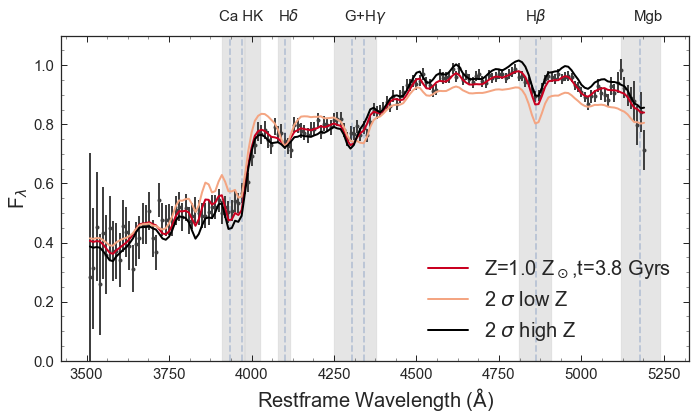

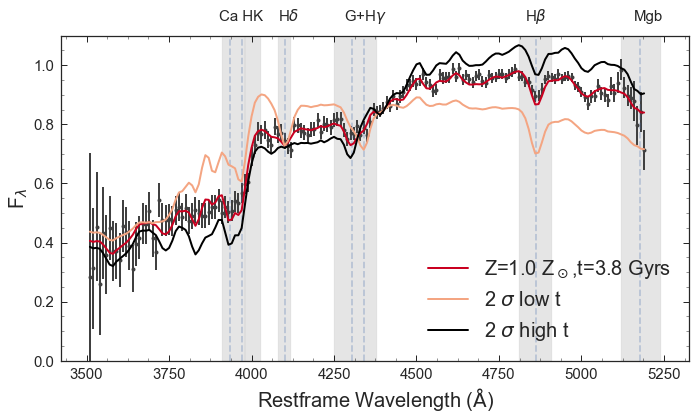

In [13]:
%matplotlib inline

Plot_stack(Mstack.wv, Mstack.fl, Mstack.er, Mstack.mwv, Mstack.mfl, 
           Zlstack.mwv, Zlstack.mfl, Zhstack.mwv, Zhstack.mfl,
           0.019,3.8,'Z',window=[3800,5300,1.1,1.1],save_plot=False,
           plot_name='../plots/stack_Z_95_2-15.png')

Plot_stack(Mstack.wv, Mstack.fl, Mstack.er, Mstack.mwv, Mstack.mfl, 
           tlstack.mwv, tlstack.mfl, thstack.mwv, thstack.mfl,
           0.019,3.8,'t',window=[3800,5300,1.1,1.1],save_plot=False,
           plot_name='../plots/stack_t_95_2-15.png')

# Age vs Metallcity

In [3]:
"""DATA"""
PZl_grid = Gen_grid(lzDB,'Z')
PZm_grid = Gen_grid(mzDB,'Z')
PZh_grid = Gen_grid(hzDB,'Z')
PZuh_grid = Gen_grid(uhzDB,'Z')

PTl_grid = Gen_grid(lzDB,'t')
PTm_grid = Gen_grid(mzDB,'t')
PTh_grid = Gen_grid(hzDB,'t')
PTuh_grid = Gen_grid(uhzDB,'t')

PZl,PZx = Iterative_stacking(PZl_grid,metal)
PZm,PZx = Iterative_stacking(PZm_grid,metal)
PZh,PZx = Iterative_stacking(PZh_grid,metal)
PZuh,PZx = Iterative_stacking(PZuh_grid,metal)

PTl,Ptx = Iterative_stacking(PTl_grid,age)
PTm,Ptx = Iterative_stacking(PTm_grid,age)
PTh,Ptx = Iterative_stacking(PTh_grid,age)
PTuh,Ptx = Iterative_stacking(PTuh_grid,age)

wPZl = Stack_posteriors(PZl_grid,metal)
wPZm = Stack_posteriors(PZm_grid,metal)
wPZh = Stack_posteriors(PZh_grid,metal)
wPZuh = Stack_posteriors(PZuh_grid,metal)

wPTl = Stack_posteriors(PTl_grid,age)
wPTm = Stack_posteriors(PTm_grid,age)
wPTh = Stack_posteriors(PTh_grid,age)
wPTuh = Stack_posteriors(PTuh_grid,age)

Zmedl, Zll, Zhl = np.round(Median_w_Error(PZl,PZx),3)
Zmedm, Zlm, Zhm = np.round(Median_w_Error(PZm,PZx),3)
Zmedh, Zlh, Zhh = np.round(Median_w_Error(PZh,PZx),3)
Zmeduh, Zluh, Zhuh = np.round(Median_w_Error(PZuh,PZx),3)
tmedl, tll, thl = np.round(Median_w_Error(PTl,Ptx),1)
tmedm, tlm, thm = np.round(Median_w_Error(PTm,Ptx),1)
tmedh, tlh, thh = np.round(Median_w_Error(PTh,Ptx),1)
tmeduh, tluh, thuh = np.round(Median_w_Error(PTuh,Ptx),1)

In [18]:
###PLOT-func
%matplotlib inline
def Plot_zvt(DB,PZ,PZx,PT,Ptx):
    gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[4,1],hspace=0,wspace=0)
    plt.figure(figsize=[8,8])

    plt.subplot(gs[2])
    plt.errorbar(DB['Zx_lwa'],DB['tx_lwa'],xerr=[DB['Zx_-_sig_lwa'],DB['Zx_-_sig_lwa']],yerr=[DB['tx_-_sig_lwa'],DB['tx_-_sig_lwa']],fmt='o')
    plt.axis([0,0.03,0,6])
    plt.xlabel('Metallicity (Z$_\odot$)',size=35)
    plt.ylabel('Light Weighted Age (Gyr)',size=35)
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])

    plt.subplot(gs[0])
    plt.plot(PZx,PZ,linewidth=3)
    sea.distplot(DB['Zx_lwa'],bins=10)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0,0.03)
    plt.ylim(0,max(PZ)*1.1)

    plt.subplot(gs[3])
    plt.plot(PT,Ptx,linewidth=3)
    sea.distplot(DB['tx_lwa'],bins=10,vertical=True)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(0,6)
    plt.xlim(0,max(PT)*1.1)
    plt.show()

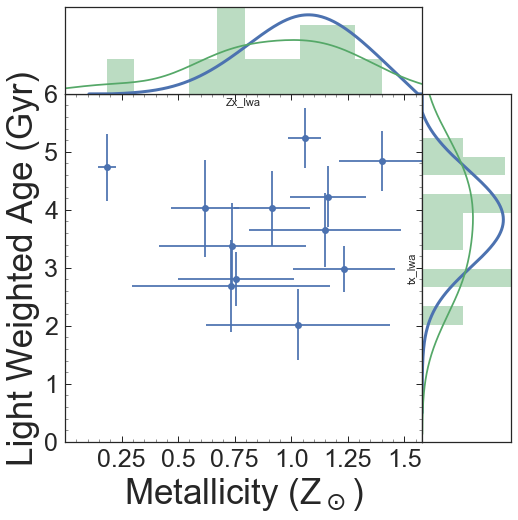

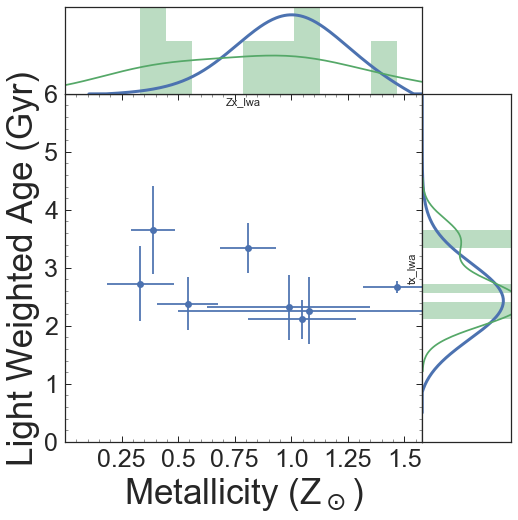

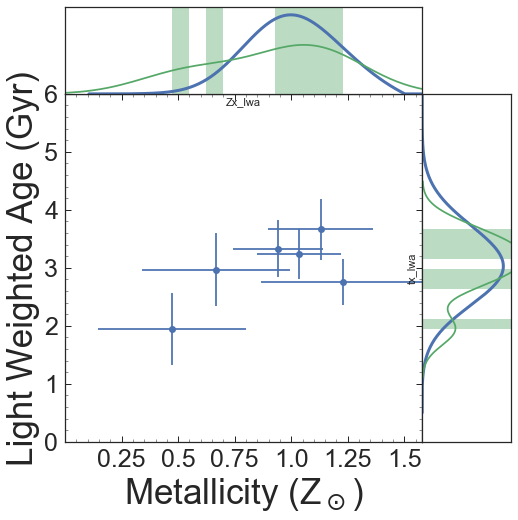

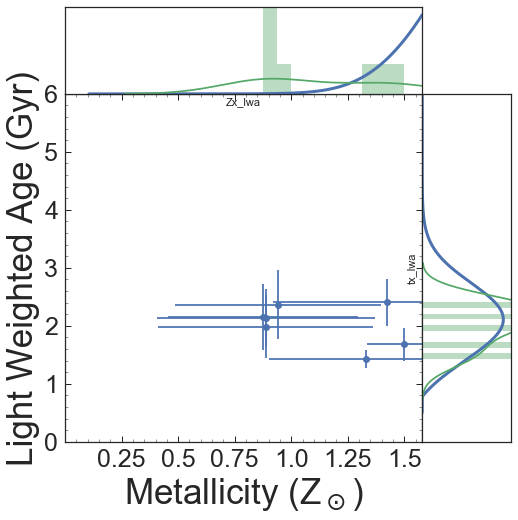

In [20]:
##Plot

Plot_zvt(lzDB,PZl,PZx,PTl,Ptx)
Plot_zvt(mzDB,PZm,PZx,PTm,Ptx)
Plot_zvt(hzDB,PZh,PZx,PTh,Ptx)
Plot_zvt(uhzDB,PZuh,PZx,PTuh,Ptx)

# Fitting Technique Compare

In [4]:
"""DATA"""
mp = [0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.017, 0.019, 0.021, 0.023, 0.025, 0.027]
ap = [3.2,2.2,1.0,3.8,2.7,1.4,4.4,3.2,1.9,5.2,3.6,2.0]

mwc,awc = np.array([[],[]])
mnc,anc = np.array([[],[]])

lwa_grid = np.load('../data/light_weight_scaling_3.npy')

lwa = []
for i in range(len(ap)):
    lwa.append(lwa_grid[np.argwhere(np.round(metal,3) == mp[i])[0][0]][np.argwhere(np.round(age,1) == ap[i])[0][0]][1])

for i in range(len(mp)):
    mdf1,adf1 = np.load('../mcerr/MC_s39170-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - lwa[i])
#     awc = np.append(awc,adf1 - ap[i])
   
    mdf1,adf1 = np.load('../mcerr/MC_n21156-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - lwa[i])
#     awc = np.append(awc,adf1 - ap[i])
    
    mdf1,adf1 = np.load('../mcerr/MC_s40862-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - lwa[i])
#     awc = np.append(awc,adf1 - ap[i])
        
    mdf1,adf1 = np.load('../mcerr/MC_s44042-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    mwc = np.append(mwc,mdf1 - mp[i])
    awc = np.append(awc,adf1 - lwa[i])
#     awc = np.append(awc,adf1 - ap[i])
        
    if i != 2 and i != 5:
        print i
        mdf1,adf1 = np.load('../mcerr/s39170_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
        mnc = np.append(mnc,mdf1 - mp[i])
        anc = np.append(anc,adf1 - lwa[i])
    #     anc = np.append(anc,adf1 - ap[i])

        mdf1,adf1 = np.load('../mcerr/n21156_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
        mnc = np.append(mnc,mdf1 - mp[i])
        anc = np.append(anc,adf1 - lwa[i])
    #     anc = np.append(anc,adf1 - ap[i])

        mdf1,adf1 = np.load('../mcerr/s40862_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
        mnc = np.append(mnc,mdf1 - mp[i])
        anc = np.append(anc,adf1 - lwa[i])
    #     anc = np.append(anc,adf1 - ap[i])

        mdf1,adf1 = np.load('../mcerr/s44042_m%s_a%s_methNC.npy' % (mp[i],ap[i]))
        mnc = np.append(mnc,mdf1 - mp[i])
        anc = np.append(anc,adf1 - lwa[i])
    #     anc = np.append(anc,adf1 - ap[i])


0
1
3
4
6
7
8
9
10
11


In [5]:
print np.percentile(mwc/0.019,50)
print np.percentile(mwc/0.019,50) - np.percentile(mwc/0.019,16)
print np.percentile(mwc/0.019,84) - np.percentile(mwc/0.019,50)
print '----'
print np.percentile(mnc/0.019,50)
print np.percentile(mnc/0.019,50) - np.percentile(mnc/0.019,16)
print np.percentile(mnc/0.019,84) - np.percentile(mnc/0.019,50)
print '----'
print np.percentile(awc,50)
print np.percentile(awc,50) - np.percentile(awc,16)
print np.percentile(awc,84) - np.percentile(awc,50)
print '----'
print np.percentile(anc,50)
print np.percentile(anc,50) - np.percentile(anc,16)
print np.percentile(anc,84) - np.percentile(anc,50)

-0.0131842632634
0.224659846008
0.193228562388
----
-0.0129733150512
0.267271384875
0.31916464508
----
0.255686762029
0.465163544688
0.590886926453
----
0.0820034120757
0.864154927293
0.713768223272


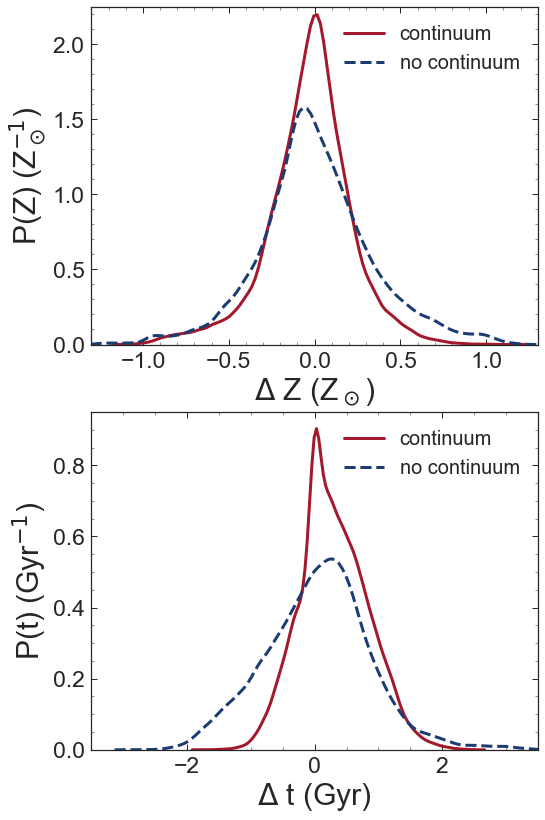

In [37]:
"""PLOT"""
%matplotlib inline

gs = gridspec.GridSpec(2,1)

plt.figure(figsize=[8,16])
plt.subplot(gs[0])
sea.distplot(mwc/0.019,hist=False,kde_kws={ "lw": 3},color = '#A3182B',label='continuum')
sea.distplot(mnc/0.019,hist=False,kde_kws={ "lw": 3,'ls':'--'},color = '#1A3C72',label='no continuum')
plt.xlabel('$\Delta$ Z (Z$_\odot$)',fontsize = 30)
plt.ylabel('P(Z) (Z$_\odot^{-1}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=20)
plt.ylim(0,2.25)
plt.xlim(-1.3,1.3)
plt.minorticks_on()

# plt.figure(figsize=[8,8])
plt.subplot(gs[1])
sea.distplot(awc,hist=False,kde_kws={ "lw": 3},color = '#A3182B',label='continuum')
sea.distplot(anc,hist=False,kde_kws={ "lw": 3,'ls':'--'},color = '#1A3C72',label='no continuum')
plt.xlabel('$\Delta$ t (Gyr)',fontsize = 30)
plt.ylabel('P(t) (Gyr$^{-1}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=20)
plt.ylim(0,.95)
plt.xlim(-3.5,3.5)
plt.minorticks_on()
# plt.show()
plt.savefig('../plots/P-Zt_2cases.pdf',bbox_inches = 'tight')
# plt.close()

#Fitting Technique Compare - Likelihoods

In [17]:
"""DATA"""
mp = [0.005,0.007,0.009,0.011,0.013,0.015,0.017,0.019,0.021,0.023,0.025,0.027]
ap = [3.2,2.2,1.0,3.8,2.7,1.4,4.4,3.2,1.9,5.2,3.6,2.0]

ID = ['s39170','n21156','s40862','s44042']

m5,m7,m9,m11,m13,m15,m17,m19,m21,m23,m25,m27 = np.array([[],[],[],[],[],[],[],[],[],[],[],[]])
a32,a22,a10,a38,a27,a14,a44,a32,a19,a52,a36,a20 = np.array([[],[],[],[],[],[],[],[],[],[],[],[]])

lwa_grid = np.load('../data/light_weight_scaling_3.npy')

lwa = []
for i in range(len(ap)):
    lwa.append(lwa_grid[np.argwhere(np.round(metal,3) == mp[i])[0][0]][np.argwhere(np.round(age,1) == ap[i])[0][0]][1])

for i in range(len(ID)):
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.005_a3.2_lwa.npy' % (ID[i]))
    m5 = np.append(m5,mdf1 - 0.005)
    a32 = np.append(awc,adf1 - 2.9972042199571378)
   
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.007_a2.2_lwa.npy' % (ID[i]))
    m7 = np.append(m7,mdf1 - 0.007)
    a22 = np.append(awc,adf1 - 1.9968182479914554)
    
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.009_a1.0_lwa.npy' % (ID[i]))
    m9 = np.append(m9,mdf1 - 0.009)
    a10 = np.append(a10,adf1 - 0.79755702404075202)
    
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.011_a3.8_lwa.npy' % (ID[i]))
    m11 = np.append(m11,mdf1 - 0.011)
    a38 = np.append(a38,adf1 - 3.5972523337611464)
        
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.013_a2.7_lwa.npy' % (ID[i]))
    m13 = np.append(m13,mdf1 - 0.013)
    a27 = np.append(a27,adf1 - 2.4975071646150622)
   
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.015_a1.4_lwa.npy' % (ID[i]))
    m15 = np.append(m15,mdf1 - 0.015)
    a14 = np.append(a14,adf1 - 1.1978963696879421)

    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.017_a4.4_lwa.npy' % (ID[i]))
    m17 = np.append(m17,mdf1 - 0.017)
    a44 = np.append(a44,adf1 - 4.1971958054552321)
    
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.019_a3.2_lwa.npy' % (ID[i]))
    m19 = np.append(m19,mdf1 - 0.019)
    a32 = np.append(a32,adf1 - 2.9965257459491612)
    
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.021_a1.9_lwa.npy' % (ID[i]))
    m21 = np.append(m21,mdf1 - 0.021)
    a19 = np.append(a19,adf1 - 1.6965537021527599)
    
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.023_a5.2_lwa.npy' % (ID[i]))
    m23 = np.append(m23,mdf1 - 0.023)
    a52 = np.append(a52,adf1 - 4.9965803729329261)
    
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.025_a3.6_lwa.npy' % (ID[i]))
    m25 = np.append(m25,mdf1 - 0.025)
    a36 = np.append(a36,adf1 - 3.3966131341911301)
    
    mdf1,adf1 = np.load('../mcerr/MC_%s-m0.027_a2.0_lwa.npy' % (ID[i]))
    m27 = np.append(m27,mdf1 - 0.027)
    a20 = np.append(a20,adf1 - 1.7966515615694527)

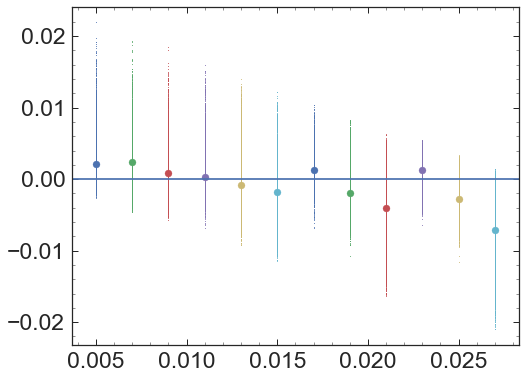

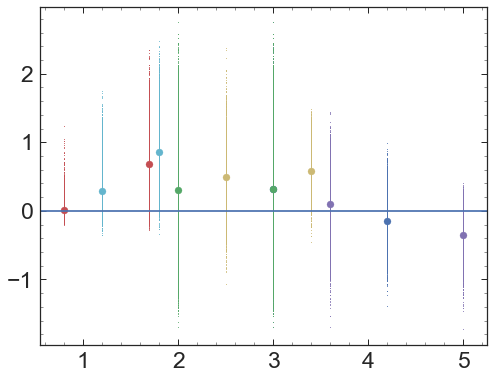

In [19]:
"""PLOTS""" # same data as above
%matplotlib inline
plt.figure(figsize=[8,16])
plt.subplot(gs[0])
plt.plot(np.repeat(0.005,len(m5)),m5,'o',ms=1)
plt.plot(np.repeat(0.007,len(m7)),m7,'o',ms=1)
plt.plot(np.repeat(0.009,len(m9)),m9,'o',ms=1)
plt.plot(np.repeat(0.011,len(m11)),m11,'o',ms=1)
plt.plot(np.repeat(0.013,len(m13)),m13,'o',ms=1)
plt.plot(np.repeat(0.015,len(m15)),m15,'o',ms=1)
plt.plot(np.repeat(0.017,len(m17)),m17,'o',ms=1)
plt.plot(np.repeat(0.019,len(m19)),m19,'o',ms=1)
plt.plot(np.repeat(0.021,len(m21)),m21,'o',ms=1)
plt.plot(np.repeat(0.023,len(m23)),m23,'o',ms=1)
plt.plot(np.repeat(0.025,len(m25)),m25,'o',ms=1)
plt.plot(np.repeat(0.027,len(m27)),m27,'o',ms=1)
plt.scatter(0.005,np.median(m5))
plt.scatter(0.007,np.median(m7))
plt.scatter(0.009,np.median(m9))
plt.scatter(0.011,np.median(m11))
plt.scatter(0.013,np.median(m13))
plt.scatter(0.015,np.median(m15))
plt.scatter(0.017,np.median(m17))
plt.scatter(0.019,np.median(m19))
plt.scatter(0.021,np.median(m21))
plt.scatter(0.023,np.median(m23))
plt.scatter(0.025,np.median(m25))
plt.scatter(0.027,np.median(m27))
plt.axhline(0)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=20)
plt.minorticks_on()
ap = [3.2,2.2,3.8,2.7,4.4,3.2,1.9,5.2,3.6,2.0]

plt.figure(figsize=[8,16])
plt.subplot(gs[0])
plt.plot(np.repeat(2.9972042199571378,len(a32)),a32,'o',ms=1)
plt.plot(np.repeat(1.9968182479914554,len(a22)),a22,'o',ms=1)
plt.plot(np.repeat(0.79755702404075202,len(a10)),a10,'o',ms=1)
plt.plot(np.repeat(3.5972523337611464,len(a38)),a38,'o',ms=1)
plt.plot(np.repeat(2.4975071646150622,len(a27)),a27,'o',ms=1)
plt.plot(np.repeat(1.1978963696879421,len(a14)),a14,'o',ms=1)
plt.plot(np.repeat(4.1971958054552321,len(a44)),a44,'o',ms=1)
plt.plot(np.repeat(2.9965257459491612,len(a32)),a32,'o',ms=1)
plt.plot(np.repeat(1.6965537021527599,len(a19)),a19,'o',ms=1)
plt.plot(np.repeat(4.9965803729329261,len(a52)),a52,'o',ms=1)
plt.plot(np.repeat(3.3966131341911301,len(a36)),a36,'o',ms=1)
plt.plot(np.repeat(1.7966515615694527,len(a20)),a20,'o',ms=1)
plt.scatter(2.9972042199571378,np.median(a32))
plt.scatter(1.9968182479914554,np.median(a22))
plt.scatter(0.79755702404075202,np.median(a10))
plt.scatter(3.5972523337611464,np.median(a38))
plt.scatter(2.4975071646150622,np.median(a27))
plt.scatter(1.1978963696879421,np.median(a14))
plt.scatter(4.1971958054552321,np.median(a44))
plt.scatter(2.9965257459491612,np.median(a32))
plt.scatter(1.6965537021527599,np.median(a19))
plt.scatter(4.9965803729329261,np.median(a52))
plt.scatter(3.3966131341911301,np.median(a36))
plt.scatter(1.7966515615694527,np.median(a20))
plt.axhline(0)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=20)
plt.minorticks_on()

# Redshift group comparison

In [14]:
def Z_group_stats(dist):
    sorted_dist = np.sort(dist)
    med = sorted_dist[499]
    lerr = sorted_dist[499] - sorted_dist[159]
    herr = sorted_dist[839] - sorted_dist[499] 
    return med, lerr, herr

In [15]:
"""DATA"""
# mp= [0.008,0.012,0.015,0.019,0.021,0.025]
# ap = [3.0,4.5,3.3,5.2,3.5,5.8]
ID = ['s39170' ,'n21566','s40862','s44042']
sn = np.array([2.0,4.0,8.0,12.0,16.0])

mp = [0.019]
ap = [5.2]

m39, ml39, mh39, a39, al39, ah39 = np.zeros([6,5])
m21, ml21, mh21, a21, al21, ah21 = np.zeros([6,5])
m40, ml40, mh40, a40, al40, ah40 = np.zeros([6,5])
m44, ml44, mh44, a44, al44, ah44 = np.zeros([6,5])

lwa_grid = np.load('../data/light_weight_scaling_3.npy')

lwa = []
for i in range(len(ap)):
    lwa.append(lwa_grid[np.argwhere(np.round(metal,3) == mp[i])[0][0]][np.argwhere(np.round(age,1) == ap[i])[0][0]][5])


for i in range(len(sn)):
    mdf1,adf1 = np.load('../mcerr/MC_s39170-z1.082_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[i],mp[0],ap[0]))
    dm = mdf1 - mp[0]
    da = adf1 - lwa[0]
    m39[i], ml39[i], mh39[i] = Z_group_stats(dm)
    a39[i], al39[i], ah39[i] = Z_group_stats(da)
    
    mdf1,adf1 = np.load('../mcerr/MC_n21156-z1.217_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[i],mp[0],ap[0]))
    dm = mdf1 - mp[0]
    da = adf1 - lwa[0]
    m21[i], ml21[i], mh21[i] = Z_group_stats(dm)
    a21[i], al21[i], ah21[i] = Z_group_stats(da)
    
    mdf1,adf1 = np.load('../mcerr/MC_s40862-z1.369_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[i],mp[0],ap[0]))
    dm = mdf1 - mp[0]
    da = adf1 - lwa[0]
    m40[i], ml40[i], mh40[i] = Z_group_stats(dm)
    a40[i], al40[i], ah40[i] = Z_group_stats(da)
 
    mdf1,adf1 = np.load('../mcerr/MC_s44042-z1.636_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[i],mp[0],ap[0]))
    dm = mdf1 - mp[0]
    da = adf1 - lwa[0]
    m44[i], ml44[i], mh44[i] = Z_group_stats(dm)
    a44[i], al44[i], ah44[i] = Z_group_stats(da) 


In [42]:
def Z_group_stats_all(dist):
    sorted_dist = np.sort(dist)
    med = sorted_dist[2999]
    lerr = sorted_dist[2999] - sorted_dist[959]
    herr = sorted_dist[5039] - sorted_dist[2999] 
    return med, lerr, herr

In [41]:
6000*.84-1

5039.0

In [55]:
"""DATA"""
mp= [0.008,0.012,0.015,0.019,0.021,0.025]
ap = [3.0,4.5,3.3,5.2,3.5,5.8]
ID = ['s39170' ,'n21566','s40862','s44042']
sn = np.array([2.0,4.0,8.0,12.0,16.0])

m39, ml39, mh39, a39, al39, ah39 = np.zeros([6,5])
m21, ml21, mh21, a21, al21, ah21 = np.zeros([6,5])
m40, ml40, mh40, a40, al40, ah40 = np.zeros([6,5])
m44, ml44, mh44, a44, al44, ah44 = np.zeros([6,5])

lwa_grid = np.load('../data/light_weight_scaling_3.npy')

lwa = []
for i in range(len(ap)):
    lwa.append(lwa_grid[np.argwhere(np.round(metal,3) == mp[i])[0][0]][np.argwhere(np.round(age,1) == ap[i])[0][0]][5])


for i in range(len(sn)):
    dm = np.array([])
    da = np.array([])
    for ii in range(len(mp)):
        mdf1,adf1 = np.load('../mcerr/MC_s39170-z1.082_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[i],mp[ii],ap[ii]))
        dm = np.append(dm,mdf1 - mp[ii])
        da = np.append(da,adf1 - lwa[ii])
    
    m39[i], ml39[i], mh39[i] = Z_group_stats_all(dm)
    a39[i], al39[i], ah39[i] = Z_group_stats_all(da)
    
    dm = np.array([])
    da = np.array([])
    for ii in range(len(mp)):
        mdf1,adf1 = np.load('../mcerr/MC_n21156-z1.217_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[i],mp[ii],ap[ii]))
        dm = np.append(dm,mdf1 - mp[ii])
        da = np.append(da,adf1 - lwa[ii])
    m21[i], ml21[i], mh21[i] = Z_group_stats_all(dm)
    a21[i], al21[i], ah21[i] = Z_group_stats_all(da)
    
    dm = np.array([])
    da = np.array([])
    for ii in range(len(mp)):
        mdf1,adf1 = np.load('../mcerr/MC_s40862-z1.369_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[i],mp[ii],ap[ii]))
        dm = np.append(dm,mdf1 - mp[ii])
        da = np.append(da,adf1 - lwa[ii])
    m40[i], ml40[i], mh40[i] = Z_group_stats_all(dm)
    a40[i], al40[i], ah40[i] = Z_group_stats_all(da)
 
    dm = np.array([])
    da = np.array([])
    for ii in range(len(mp)):
        mdf1,adf1 = np.load('../mcerr/MC_s44042-z1.636_sn{0}_m{1}_a{2}_lwa.npy'.format(sn[i],mp[ii],ap[ii]))
        dm = np.append(dm,mdf1 - mp[ii])
        da = np.append(da,adf1 - lwa[ii])
    m44[i], ml44[i], mh44[i] = Z_group_stats_all(dm)
    a44[i], al44[i], ah44[i] = Z_group_stats_all(da) 


-0.000334669338677


(array([   16.,    56.,   233.,   797.,  2070.,  1858.,   669.,   228.,
           59.,    14.]),
 array([ -1.76533066e-02,  -1.41368737e-02,  -1.06204409e-02,
         -7.10400802e-03,  -3.58757515e-03,  -7.11422846e-05,
          3.44529058e-03,   6.96172345e-03,   1.04781563e-02,
          1.39945892e-02,   1.75110220e-02]),
 <a list of 10 Patch objects>)

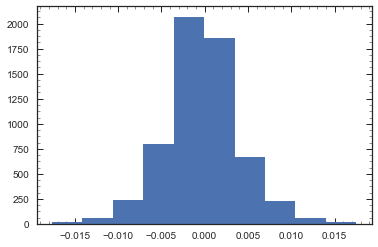

In [37]:
print np.median(dm)
plt.hist(dm)

In [103]:
print np.round(m40[3]/0.019,3),np.round(ml40[3]/0.019,2),np.round(mh40[3]/0.019,2)
print np.round(a40[3]/3.95,3),np.round(al40[3]/3.95,2), np.round(ah40[3]/3.95,2)

-0.047 0.09 0.19
-0.014 0.1 0.11


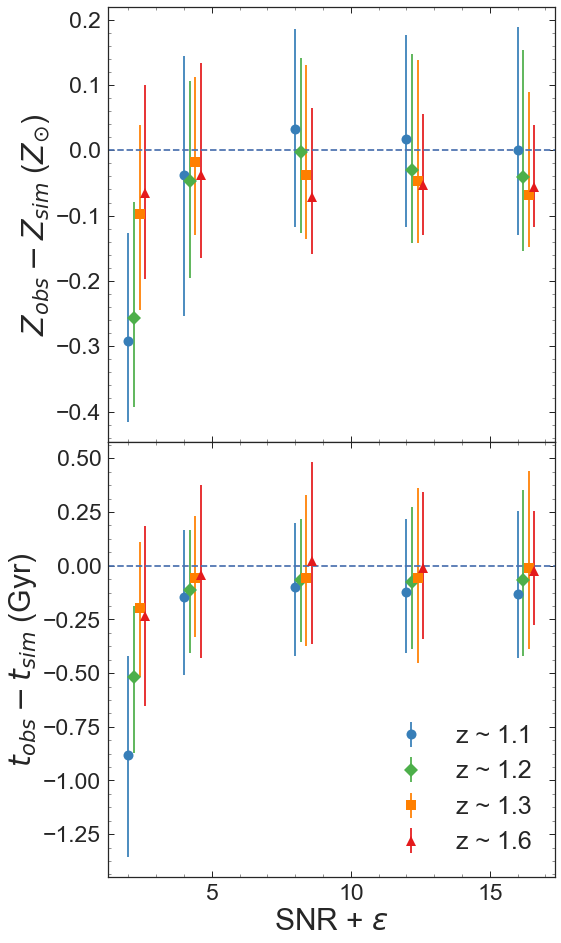

In [19]:
"""PLOT"""
%matplotlib inline
gs = gridspec.GridSpec(2,1,hspace=0)
plt.figure(figsize=[8,16])
plt.subplot(gs[0])
plt.errorbar(sn,m39/.019,yerr=[ml39/.019,mh39/.019],fmt='o',color='#377eb8',label='z ~ 1.1',ms=10)
plt.errorbar(sn+.2,m21/.019,yerr=[ml21/.019,mh21/.019],fmt='D',color='#4daf4a',label='z ~ 1.2',ms=10)
plt.errorbar(sn+.4,m40/.019,yerr=[ml40/.019,mh40/.019],fmt='s',color='#ff7f00',label='z ~ 1.3',ms=10)
plt.errorbar(sn+.6,m44/.019,yerr=[ml44/.019,mh44/.019],fmt='^',color='#e41a1c',label='z ~ 1.6',ms=10)
plt.axhline(0,linestyle='--')
plt.ylabel('$Z_{obs} - Z_{sim}$ ($Z_{\odot}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
# plt.axhline(-0.03)

plt.subplot(gs[1])
plt.errorbar(sn,a39,yerr=[al39,ah39],fmt='o',color='#377eb8',label='z ~ 1.1',ms=10)
plt.errorbar(sn+.2,a21,yerr=[al21,ah21],fmt='D',color='#4daf4a',label='z ~ 1.2',ms=10)
plt.errorbar(sn+.4,a40,yerr=[al40,ah40],fmt='s',color='#ff7f00',label='z ~ 1.3',ms=10)
plt.errorbar(sn+.6,a44,yerr=[al44,ah44],fmt='^',color='#e41a1c',label='z ~ 1.6',ms=10)
plt.xlabel('SNR + $\epsilon$',fontsize = 30)
plt.ylabel('$t_{obs} - t_{sim}$ (Gyr)',fontsize = 30)
plt.axhline(0,linestyle='--')
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(fontsize=25)
# plt.axhline(0.1)

plt.savefig('../plots/groups_Zt.pdf',bbox_inches = 'tight')


(-2.25, 2.25)

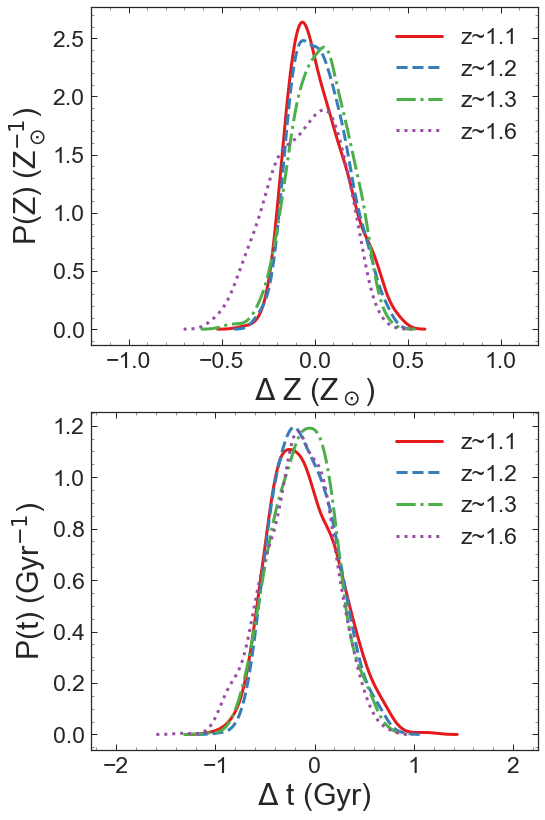

In [8]:
"""PLOT"""
%matplotlib inline
gs = gridspec.GridSpec(2,1)
plt.figure(figsize=[8,16])
plt.subplot(gs[0])
sea.distplot(ms39/.019,color='#e41a1c',kde_kws={ "lw": 3},hist=False,label='z~1.1')
sea.distplot(mn21/.019,color='#377eb8',kde_kws={ "lw": 3,'ls':'--'},hist=False,label='z~1.2')
sea.distplot(ms40/.019,color='#4daf4a',kde_kws={ "lw": 3,'ls':'-.'},hist=False,label='z~1.3')
sea.distplot(ms44/.019,color='#984ea3',kde_kws={ "lw": 3,'ls':':'},hist=False,label='z~1.6')
plt.xlabel('$\Delta$ Z (Z$_\odot$)',fontsize = 30)
plt.ylabel('P(Z) (Z$_\odot^{-1}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
# plt.ylim(0,3)
plt.xlim(-1.2,1.2)

plt.subplot(gs[1])
sea.distplot(as39,color='#e41a1c',hist=False,kde_kws={ "lw": 3},label='z~1.1')
sea.distplot(an21,color='#377eb8',hist=False,kde_kws={ "lw": 3,'ls':'--'},label='z~1.2')
sea.distplot(as40,color='#4daf4a',hist=False,kde_kws={ "lw": 3,'ls':'-.'},label='z~1.3')
sea.distplot(as44,color='#984ea3',hist=False,kde_kws={ "lw": 3,'ls':':'},label='z~1.6')
plt.xlabel('$\Delta$ t (Gyr)',fontsize = 30)
plt.ylabel('P(t) (Gyr$^{-1}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
# plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
# plt.ylim(0,1.2)
plt.xlim(-2.25,2.25)
# plt.show()
# plt.savefig('../plots/groups_Zt.pdf',bbox_inches = 'tight')
# plt.close()


In [9]:
ms39,as39 = np.array([[],[]])
mn21,an21 = np.array([[],[]])
pm39,pa39 = np.array([[],[]])
pm21,pa21 = np.array([[],[]])
ms40,as40 = np.array([[],[]])
ms44,as44 = np.array([[],[]])

lwa_grid = np.load('../data/light_weight_scaling_3.npy')

lwa = []
for i in range(len(ap)):
    lwa.append(lwa_grid[np.argwhere(np.round(metal,3) == mp[i])[0][0]][np.argwhere(np.round(age,1) == ap[i])[0][0]][5])


for i in range(len(mp)):
    mdf1,adf1 = np.load('../mcerr/MC_s39170-z1.082_sn16.0_m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms39 = np.append(ms39,mdf1)
    as39 = np.append(as39,adf1)
    
    mdf1,adf1 = np.load('../mcerr/MC_s39170-z1.082_sn12.0_m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    mn21 = np.append(mn21,mdf1)
    an21 = np.append(an21,adf1)
    
    mdf1,adf1 = np.load('../mcerr/MC_s39170-z1.082_sn8.0_m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms40 = np.append(ms40,mdf1)
    as40 = np.append(as40,adf1)
 
    mdf1,adf1 = np.load('../mcerr/MC_s39170-z1.082_sn4.0_m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms44 = np.append(ms44,mdf1)
    as44 = np.append(as44,adf1) 


In [11]:
print lwa

[3.9505377271291819]


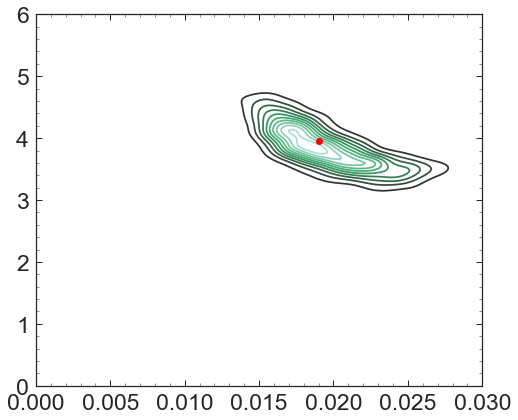

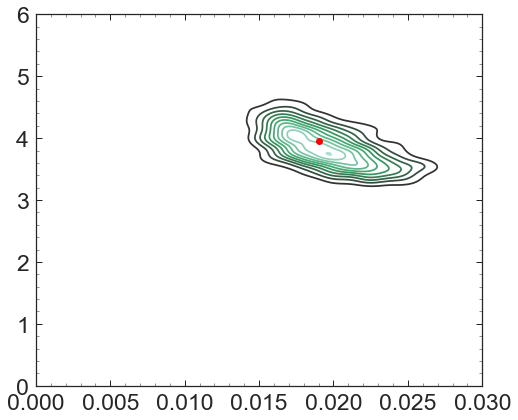

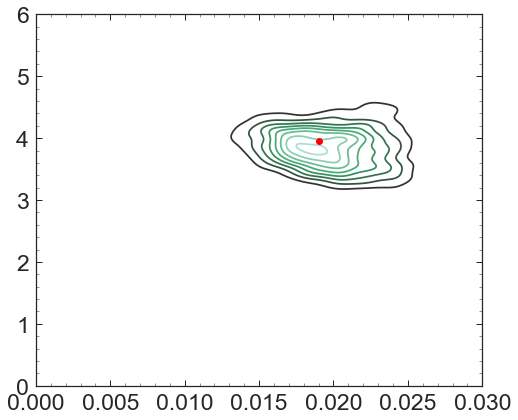

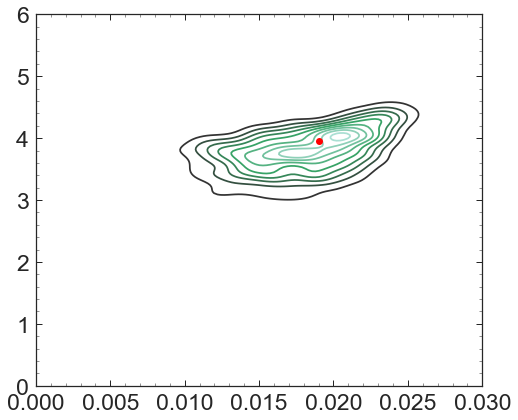

In [12]:
"""PLOT"""
%matplotlib inline
plt.figure(figsize=[8,8])
sea.kdeplot(ms39,as39)
plt.plot(0.019,3.95,'ro')
plt.axis([0,0.03,0,6])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)

plt.figure(figsize=[8,8])
sea.kdeplot(mn21,an21)
plt.axis([0,0.03,0,6])
plt.plot(0.019,3.95,'ro')
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)

plt.figure(figsize=[8,8])
sea.kdeplot(ms40,as40)
plt.axis([0,0.03,0,6])
plt.plot(0.019,3.95,'ro')
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)

plt.figure(figsize=[8,8])
sea.kdeplot(ms44,as44)
plt.plot(0.019,3.95,'ro')
plt.axis([0,0.03,0,6])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)

-0.238209752839
0.18082071836
-----
-0.208283233133
0.24763813341
-0.0306562830832
0.321240205893
-----
-0.0552311730508
0.269617431525


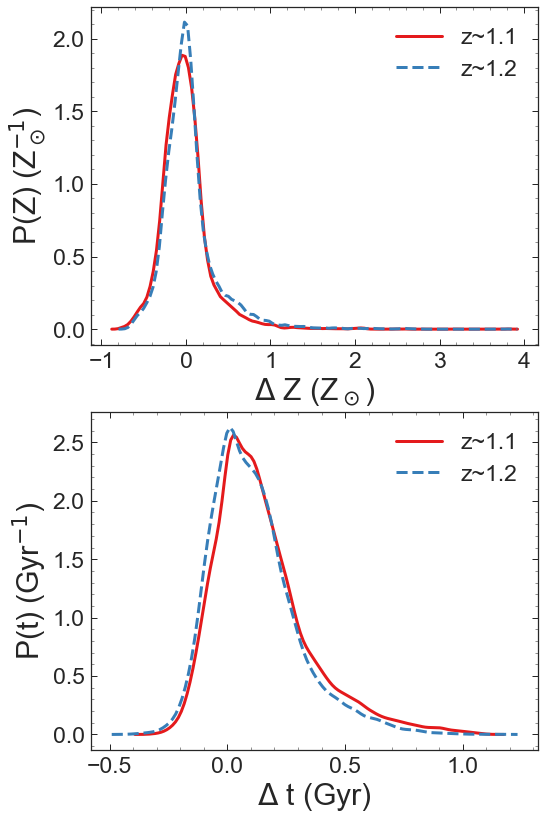

In [21]:
"""PLOT"""
%matplotlib inline

print np.percentile(pm39,16)
print np.percentile(pm39,84)
print '-----'
print np.percentile(pm21,16)
print np.percentile(pm21,84)

print np.percentile(pa39,16)
print np.percentile(pa39,84)
print '-----'
print np.percentile(pa21,16)
print np.percentile(pa21,84)

gs = gridspec.GridSpec(2,1)
plt.figure(figsize=[8,16])
plt.subplot(gs[0])
sea.distplot(pm39,color='#e41a1c',kde_kws={ "lw": 3},hist=False,label='z~1.1')
sea.distplot(pm21,color='#377eb8',kde_kws={ "lw": 3,'ls':'--'},hist=False,label='z~1.2')

plt.xlabel('$\Delta$ Z (Z$_\odot$)',fontsize = 30)
plt.ylabel('P(Z) (Z$_\odot^{-1}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
# plt.ylim(0,3)
# plt.xlim(-1.2,1.2)

plt.subplot(gs[1])
sea.distplot(pa39,color='#e41a1c',hist=False,kde_kws={ "lw": 3},label='z~1.1')
sea.distplot(pa21,color='#377eb8',hist=False,kde_kws={ "lw": 3,'ls':'--'},label='z~1.2')

plt.xlabel('$\Delta$ t (Gyr)',fontsize = 30)
plt.ylabel('P(t) (Gyr$^{-1}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(fontsize=23)
# plt.ylim(0,1.2)
# plt.xlim(-2.25,2.25)


(-3.5, 3.5)

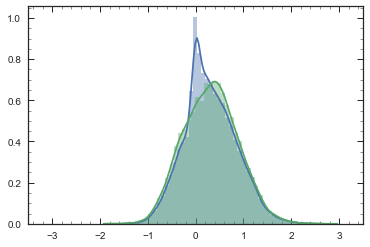

In [12]:
sea.distplot(test)
sea.distplot(awc)
plt.xlim(-3.5,3.5)


In [45]:
#percent error
"""DATA"""
mp = [0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.017, 0.019, 0.021, 0.023, 0.025, 0.027]
ap = [3.2,2.2,1.0,3.8,2.7,1.4,4.4,3.2,1.9,5.2,3.6,2.0]

ms39,as39 = np.array([[],[]])
mn21,an21 = np.array([[],[]])
ms40,as40 = np.array([[],[]])
ms44,as44 = np.array([[],[]])

lwa_grid = np.load('../data/light_weight_scaling_3.npy')

lwa = []
for i in range(len(ap)):
    lwa.append(lwa_grid[np.argwhere(np.round(metal,3) == mp[i])[0][0]][np.argwhere(np.round(age,1) == ap[i])[0][0]][1])


for i in range(len(mp)):
    mdf1,adf1 = np.load('../mcerr/MC_s39170-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms39 = np.append(ms39,(mdf1 - mp[i])/mp[i])
#     as39 = np.append(as39,adf1 - ap[i])
    as39 = np.append(as39,(adf1 - lwa[i])/ap[i])

    mdf1,adf1 = np.load('../mcerr/MC_n21156-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    mn21 = np.append(mn21,(mdf1 - mp[i])/mp[i])
#     an21 = np.append(an21,adf1 - ap[i])
    an21 = np.append(an21,(adf1 - lwa[i])/ap[i])

    
    mdf1,adf1 = np.load('../mcerr/MC_s40862-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms40 = np.append(ms40,(mdf1 - mp[i])/mp[i])
#     as40 = np.append(as40,adf1 - ap[i])
    as40 = np.append(as40,(adf1 - lwa[i])/ap[i])

    
    mdf1,adf1 = np.load('../mcerr/MC_s44042-m%s_a%s_lwa.npy' % (mp[i],ap[i]))
    ms44 = np.append(ms44,(mdf1 - mp[i])/mp[i])
#     as44 = np.append(as44,adf1 - ap[i])
    as44 = np.append(as44,(adf1 - lwa[i])/ap[i]) 

In [32]:
27/19.

1.4210526315789473

(-1.3, 1.3)

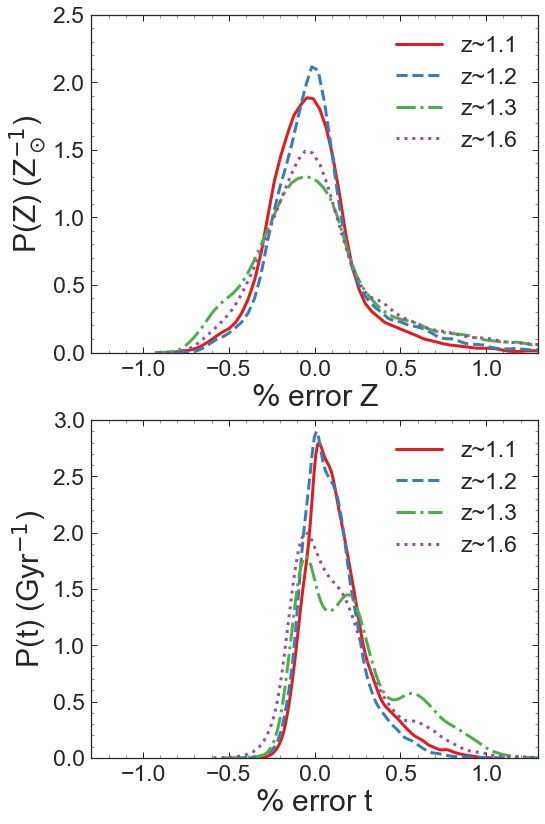

In [54]:
"""PLOT"""
%matplotlib inline
gs = gridspec.GridSpec(2,1)
plt.figure(figsize=[8,16])
plt.subplot(gs[0])
sea.distplot(ms39,color='#e41a1c',kde_kws={ "lw": 3},hist=False,label='z~1.1')
sea.distplot(mn21,color='#377eb8',kde_kws={ "lw": 3,'ls':'--'},hist=False,label='z~1.2')
sea.distplot(ms40,color='#4daf4a',kde_kws={ "lw": 3,'ls':'-.'},hist=False,label='z~1.3')
sea.distplot(ms44,color='#984ea3',kde_kws={ "lw": 3,'ls':':'},hist=False,label='z~1.6')
plt.xlabel('$\%$ error Z',fontsize = 30)
plt.ylabel('P(Z) (Z$_\odot^{-1}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
plt.ylim(0,2.5)
plt.xlim(-1.3,1.3)

plt.subplot(gs[1])
sea.distplot(as39,color='#e41a1c',hist=False,kde_kws={ "lw": 3},label='z~1.1')
sea.distplot(an21,color='#377eb8',hist=False,kde_kws={ "lw": 3,'ls':'--'},label='z~1.2')
sea.distplot(as40,color='#4daf4a',hist=False,kde_kws={ "lw": 3,'ls':'-.'},label='z~1.3')
sea.distplot(as44,color='#984ea3',hist=False,kde_kws={ "lw": 3,'ls':':'},label='z~1.6')
plt.xlabel('$\%$ error t',fontsize = 30)
plt.ylabel('P(t) (Gyr$^{-1}$)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
# plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(fontsize=23)
plt.ylim(0,3)
plt.xlim(-1.3,1.3)
# plt.show()
# plt.savefig('../plots/groups_Zt.pdf',bbox_inches = 'tight')
# plt.close()

In [56]:
print np.percentile(ms39,50)
print np.percentile(ms39,50) - np.percentile(ms39,16)
print np.percentile(ms39,84) - np.percentile(ms39,50)
print '-----'
print np.percentile(mn21,50)
print np.percentile(mn21,50) - np.percentile(mn21,16)
print np.percentile(mn21,84) - np.percentile(mn21,50)
print '-----'
print np.percentile(ms40,50)
print np.percentile(ms40,50) - np.percentile(ms40,16)
print np.percentile(ms40,84) - np.percentile(ms40,50)
print '-----'
print np.percentile(ms44,50)
print np.percentile(ms44,50) - np.percentile(ms44,16)
print np.percentile(ms44,84) - np.percentile(ms44,50)
print '-----'

print np.percentile(as39,50)
print np.percentile(as39,50) - np.percentile(as39,16)
print np.percentile(as39,84) - np.percentile(as39,50)
print '-----'
print np.percentile(an21,50)
print np.percentile(an21,50) - np.percentile(an21,16)
print np.percentile(an21,84) - np.percentile(an21,50)
print '-----'
print np.percentile(as40,50)
print np.percentile(as40,50) - np.percentile(as40,16)
print np.percentile(as40,84) - np.percentile(as40,50)
print '-----'
print np.percentile(as44,50)
print np.percentile(as44,50) - np.percentile(as44,16)
print np.percentile(as44,84) - np.percentile(as44,50)
print '-----'


-0.0360276107771
0.202182142062
0.216848329137
-----
-0.00649298597194
0.201790247161
0.254131119382
-----
-0.022782625292
0.296299984372
0.431126528785
-----
-0.00548923934826
0.260200033935
0.445512142297
-----
0.0992365631336
0.128257190993
0.194822425621
-----
0.0765960676135
0.126761965508
0.169601277209
-----
0.165937456045
0.231566254447
0.381915832243
-----
0.0807208756522
0.179983789741
0.284981399675
-----


# Data plot

In [3]:
%matplotlib inline

img1=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.2D.fits')
img2=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-21-092-G102_39170.2D.fits')
img3=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-22-142-G102_39170.2D.fits')

print img1.info()

Filename: ../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.2D.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      36   ()      
  1  DSCI        ImageHDU        51   (36, 36)   float64   
  2  DINTER      ImageHDU        51   (36, 36)   float64   
  3  DWHT        ImageHDU        51   (36, 36)   float32   
  4  DSEG        ImageHDU        51   (36, 36)   int32   
  5  SCI         ImageHDU        52   (360, 36)   float64   
  6  WHT         ImageHDU        53   (360, 36)   float64   
  7  MODEL       ImageHDU        53   (360, 36)   float64   
  8  CONTAM      ImageHDU        53   (360, 36)   float64   
  9  WAVE        ImageHDU        52   (360,)   float64   
 10  SENS        ImageHDU        53   (360,)   float64   
 11  YTRACE      ImageHDU        53   (360,)   float64   
None


In [ ]:
field.info()

Filename: ../../Grizlsim/s39170_cmb_flt.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     282   ()              
1    SCI         ImageHDU        58   (1614, 1614)   float32   
2    ERR         ImageHDU        58   (1614, 1614)   float32   
3    DQ          ImageHDU        58   (1614, 1614)   int64   


In [96]:
%matplotlib inline

# plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img1['DSCI'].data[::-1]),vmin = 0)
# plt.imshow(np.arcsinh(img1['SCI'].data[::-1,60:330] - img1['CONTAM'].data[::-1,60:330]),vmin = 0)
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_dir1.eps',format = 'eps',dpi = 72)
# plt.show()
plt.close()

# plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img2['DSCI'].data[::-1]),vmin = 0)
# plt.imshow(np.arcsinh((img2['SCI'].data[::-1,60:330] - img2['CONTAM'].data[::-1,60:330])),vmin = 0)
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_dir2.eps',format = 'eps',dpi = 72)
# plt.show()
plt.close()
# 
# plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img3['DSCI'].data[::-1]),vmin = 0)
# plt.imshow(np.arcsinh((img3['SCI'].data[::-1,60:330] - img3['CONTAM'].data[::-1,60:330])),vmin = 0)
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_dir3.eps',format = 'eps',dpi = 72)
# plt.show()
plt.close()

# 2D fit example

In [3]:
#DATA

img1=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.2D.fits')
# img2=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-21-092-G102_39170.2D.fits')
# img3=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-22-142-G102_39170.2D.fits')

spec = Gen_spec('s39170', 1.022)
spec.Sim_spec(galDB['Z_lwa'][220],galDB['t_lwa'][220],8.0, gen_2d =True)

# print img1.info()

No TEAL-based tasks available for this package!
../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


In [22]:
#readjust
modelw = spec.model_w
modelh = np.arange(spec.beam.beam.sh_beam[0])
imgw = img1['WAVE'].data
imgh = np.arange(img1['SCI'].data.shape[0])

adj_model = interp2d(modelw,modelh,spec.model_2d)(imgw,modelh)           
# cframe = interp2d(metal, scale[ii], Cchi[ii])(metal, age[:-overhead[ii]])



In [31]:
print modelh.size
print imgh.size

52
36


In [37]:
adj = np.max(img1['SCI'].data)/np.max(adj_model[8:-8,:])

In [40]:
np.max(adj_model[8:-8,:]*adj)

0.11742242620221079

([], <a list of 0 Text xticklabel objects>)

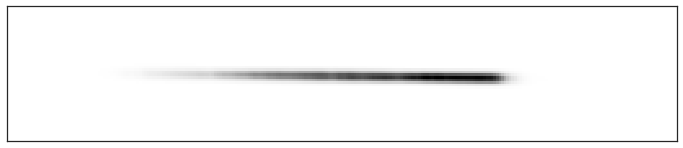

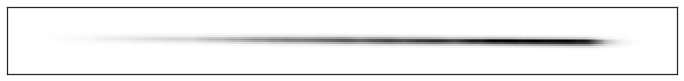

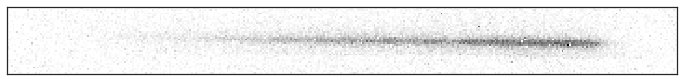

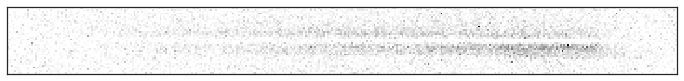

In [97]:
#plot
%matplotlib inline

plt.figure(figsize=[12,4])
plt.imshow(spec.model_2d)
plt.yticks([])
plt.xticks([])

plt.figure(figsize=[12,4])
plt.imshow(adj_model[9:-7,:])
plt.yticks([])
plt.xticks([])

plt.figure(figsize=[12,4])
plt.imshow(np.arcsinh(img1['SCI'].data - img1['CONTAM'].data),vmin = 0)
plt.yticks([])
plt.xticks([])

plt.figure(figsize=[12,4])
plt.imshow(img1['SCI'].data - img1['CONTAM'].data - adj_model[9:-7,:]*adj*.6,vmin = 0)
plt.yticks([])
plt.xticks([])



In [69]:
model_mid = np.array(adj_model[9:-7,:]*adj).T[200]
img_mid = np.array(img1['SCI'].data - img1['CONTAM'].data).T[200]

In [95]:
m_stds = np.zeros(imgw.size)
i_stds = np.zeros(imgw.size)
for i in range(len(imgw)):
    m_stds[i] = np.std(np.array(adj_model[9:-7,:]*adj*.6).T[i])
    i_stds[i] = np.std(np.array(img1['SCI'].data - img1['CONTAM'].data).T[i])
    
m_max = np.zeros(imgw.size)
i_max = np.zeros(imgw.size)
for i in range(len(imgw)):
    m_max[i] = np.max(np.array(adj_model[9:-7,:]*adj*.6).T[i])
    i_max[i] = np.max(np.array(img1['SCI'].data - img1['CONTAM'].data).T[i])

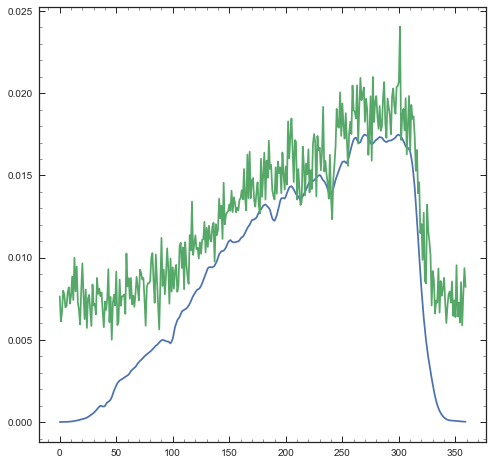

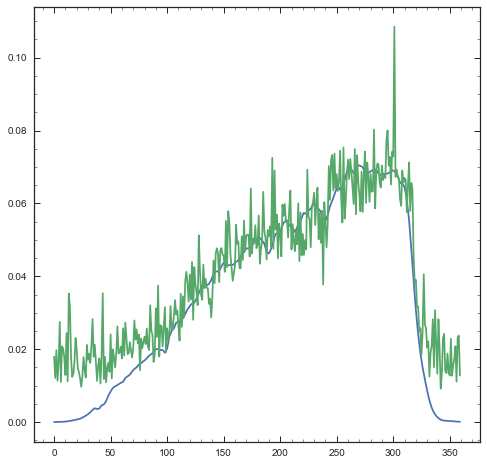

In [96]:
plt.figure(figsize=[8,8])
plt.plot(m_stds)
plt.plot(i_stds)

plt.figure(figsize=[8,8])
plt.plot(m_max)
plt.plot(i_max)

# Photometry plots

In [151]:
###DATA
smpDB = pd.read_pickle('../data/sim_meas_phot.pkl')
smpDB = smpDB[smpDB['gal_ids'] != 's35774']
f098DB = smpDB[smpDB['meas-f098'] > 0]
f850DB = smpDB[smpDB['meas-f850'] > 0]
f105DB = smpDB[smpDB['meas-f105'] > 0]

def Magnitude(flam):
    mag=-2.5*np.log10(flam)
    return mag

Clam = 3E18 / 10475.92199 **2 * 10**((-1.1)/2.5-29)

SNr = []

for i in f098DB.index:
    spec = Gen_spec(f098DB['gal_ids'][i], float(galDB['hi_res_specz'][galDB['gids'] == f098DB['gal_ids'][i]]),maxwv=11400)
    fl = np.trapz(spec.gal_fl,spec.gal_wv)
    er = np.trapz(spec.gal_er,spec.gal_wv)
    SNr.append(fl/er)

../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat
../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../dat

In [66]:
print -25-Magnitude(f105DB['meas-f105']/Clam)
# print len(Magnitude(f105DB['sim-f105']/f105DB['meas-f105']))

43    -22.5448
49    -21.5979
50    -21.6091
58    -23.3542
61    -21.3358
62    -22.5669
69    -22.8938
86    -22.1206
96    -21.2878
107   -21.8053
110   -22.6226
217   -21.8646
219   -23.3462
220   -20.6981
221   -21.2453
223   -21.7477
224   -22.1838
225   -23.0049
227   -23.4668
228   -22.4279
230   -21.3022
231   -22.9147
232   -22.2341
234   -23.1320
235   -22.9333
236   -24.0746
246   -22.1832
248   -22.5803
251   -22.4997
258   -21.4281
259   -22.3644
260   -23.6325
267   -22.9648
270   -21.5716
Name: meas-f105, dtype: float64


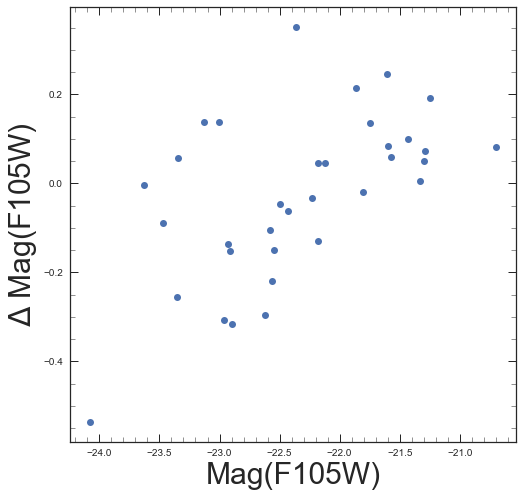

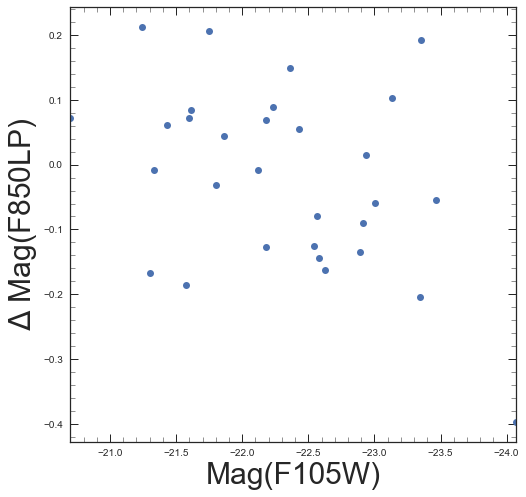

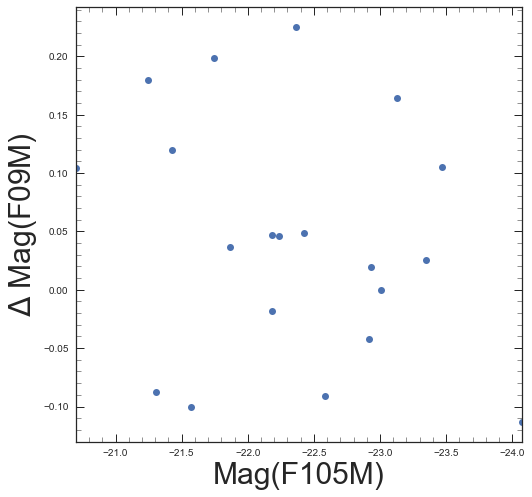

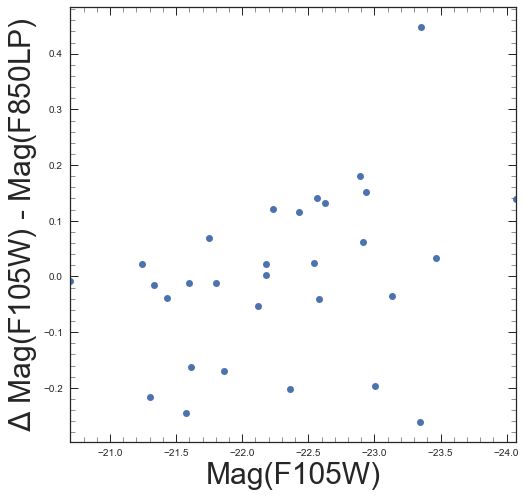

In [148]:
###PLOT 
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f105DB['meas-f105']/Clam),Magnitude(f105DB['sim-f105']/f105DB['meas-f105']),'o')
plt.ylabel('$\Delta$ Mag(F105W)',fontsize = 30)
plt.xlabel('Mag(F105W)',fontsize = 30)
# plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df105.png')
plt.close()

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f850DB['meas-f105']/Clam),Magnitude(f850DB['sim-f850']/f850DB['meas-f850']),'o')
plt.ylabel('$\Delta$ Mag(F850LP)',fontsize = 30)
plt.xlabel('Mag(F105W)',fontsize = 30)
plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df850.png')
plt.close()

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f098DB['meas-f105']/Clam),Magnitude(f098DB['sim-f098']/f098DB['meas-f098']),'o')
plt.ylabel('$\Delta$ Mag(F09M)',fontsize = 30)
plt.xlabel('Mag(F105M)',fontsize = 30)
plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df098.png')
plt.close()

plt.figure(figsize=[8,8])
plt.plot(-25-Magnitude(f850DB['meas-f105']/Clam),Magnitude((f850DB['sim-f850']*f850DB['meas-f105'])/(f850DB['meas-f850']*f850DB['sim-f105'])),'o')
plt.ylabel('$\Delta$ Mag(F105W) - Mag(F850LP)',fontsize = 30)
plt.xlabel('Mag(F105W)',fontsize = 30)
plt.xlim(max(-25-Magnitude(smpDB['meas-f105']/Clam)),min(-25-Magnitude(smpDB['meas-f105']/Clam)))
plt.show()
# plt.savefig('../plots/df105_f850.png')
plt.close()

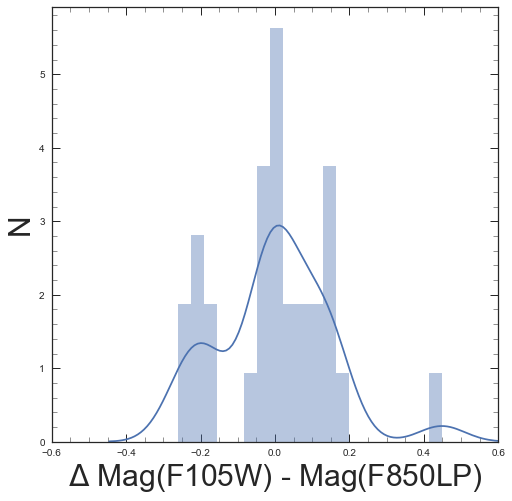

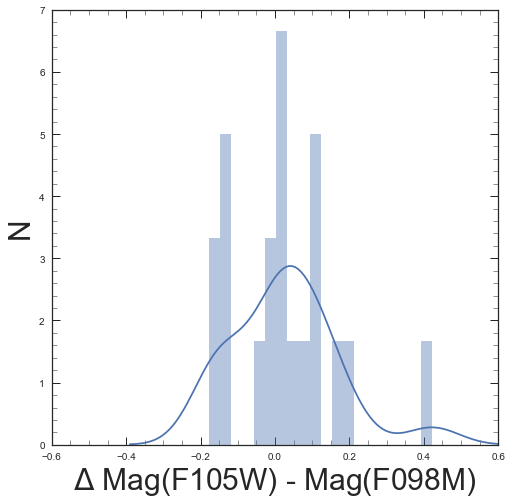

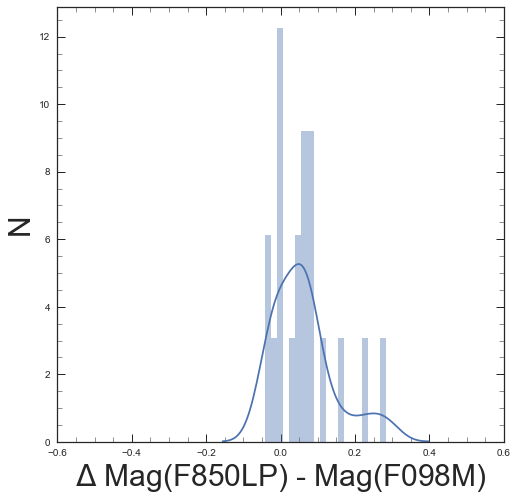

In [147]:
###PLOT 
%matplotlib inline

plt.figure(figsize=[8,8])
sea.distplot(Magnitude((f850DB['sim-f850']*f850DB['meas-f105'])/(f850DB['meas-f850']*f850DB['sim-f105'])),20)
plt.xlabel('$\Delta$ Mag(F105W) - Mag(F850LP)',fontsize = 30)
plt.ylabel('N',fontsize = 30)
plt.xlim(-.6,.6)
plt.show()
# plt.savefig('../plots/df105_850_dist.png')
plt.close()

plt.figure(figsize=[8,8])
sea.distplot(Magnitude((f098DB['sim-f098']*f098DB['meas-f105'])/(f098DB['meas-f098']*f098DB['sim-f105'])),20)
plt.xlabel('$\Delta$ Mag(F105W) - Mag(F098M)',fontsize = 30)
plt.ylabel('N',fontsize = 30)
plt.xlim(-.6,.6)
plt.show()
# plt.savefig('../plots/df105_f098_dist.png')
plt.close()

plt.figure(figsize=[8,8])
sea.distplot(Magnitude((f098DB['sim-f098']*f098DB['meas-f850'])/(f098DB['meas-f098']*f098DB['sim-f850'])),20)
plt.xlabel('$\Delta$ Mag(F850LP) - Mag(F098M)',fontsize = 30)
plt.ylabel('N',fontsize = 30)
plt.xlim(-.6,.6)
plt.show()
# plt.savefig('../plots/df850_f098_dist.png')
plt.close()

In [157]:
###PLOT 
%matplotlib inline


plt.figure(figsize=[8,8])
plt.plot(SNr,Magnitude((f098DB['sim-f098']*f098DB['meas-f850'])/(f098DB['meas-f098']*f098DB['sim-f850'])),'o')
# plt.axhline(medr,color = 'r')
# plt.axhline(medr-mlerrr,color = 'k')
# plt.axhline(medr+mherrr,color = 'k')
plt.ylabel('$\Delta$ (Mag(F098M) - Mag(F850LP))',fontsize = 30)
plt.xlabel('Integrated SN',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.gcf().subplots_adjust(left=0.15)
# plt.show()
plt.savefig('../plots/d_f098_f850.pdf')
plt.close()

In [150]:
f098DB.columns

Index([u'f098-effwv', u'f105-effwv', u'f850-effwv', u'gal_ids', u'meas-f098',
       u'meas-f098_err', u'meas-f105', u'meas-f105_err', u'meas-f850',
       u'meas-f850_err', u'sim-f098', u'sim-f098_err', u'sim-f105',
       u'sim-f105_err', u'sim-f850', u'sim-f850_err'],
      dtype='object')

# Stacking examples

In [216]:
### DATA
x=np.arange(0,6,0.05)
ers = np.arange(0,1.5,0.001)
gdist = Gauss_dist(x,3,.75)
sp_size = 12
dist_grid= np.zeros([sp_size,x.size])

for i in range(sp_size):
    dist_grid[i] = Gauss_dist(x,np.random.normal(3,.75),np.random.choice(ers))
    

In [285]:
### DATA II

Pos = Stack_posteriors(dist_grid,x)
iterpos,iterx= Iterative_stacking(dist_grid,x,resampling=250)

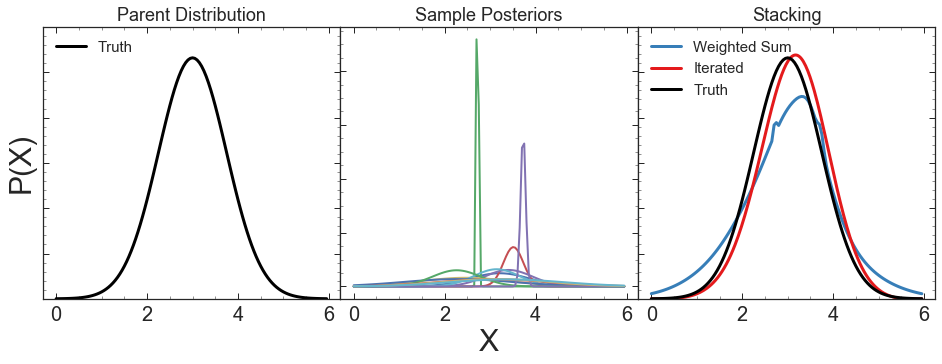

In [293]:
### PLOT
%matplotlib inline

gs = gridspec.GridSpec(1,3,wspace=0)

plt.figure(figsize=[16,5])
plt.subplot(gs[0])
plt.plot(x,gdist,'k',label='Truth',lw=3)
plt.legend(loc=2,fontsize=15)
plt.gca().tick_params(axis='y',labelleft='off')
plt.ylabel('P(X)',fontsize=30)
plt.ylim(0,.6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Parent Distribution', fontsize =18)

plt.subplot(gs[1])
for i in range(sp_size):
    plt.plot(x,dist_grid[i],lw=2)
plt.gca().tick_params(axis='y',labelleft='off')
plt.xlabel('X',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Sample Posteriors', fontsize =18)

plt.subplot(gs[2])
plt.plot(x,Pos,color='#377eb8',label = 'Weighted Sum',lw=3)
plt.plot(iterx,iterpos,color='#e41a1c',label = 'Iterated',lw=3)
plt.plot(x,gdist,'k',label = 'Truth',lw=3)
# plt.plot(x,Pos,color='#377eb8',label = 'Weighted Sum',lw=3)
# plt.plot(iterx,iterpos,color='#e41a1c',label = 'Iterated',lw=3)
plt.title('Stacking', fontsize =18)
plt.ylim(0,.6)
plt.gca().tick_params(axis='y',labelleft='off')
plt.legend(loc=2,fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/stacking_exam_1.pdf',bbox_inches = 'tight')


In [219]:
print Median_w_Error_cont(gdist,x)
print Median_w_Error_cont(Pos,x)
print Median_w_Error_cont(iterpos,iterx)

(3.0048096192384772, 0.73927855711422863, 0.75120240480961931)
(3.0882765531062129, 1.0373747494989982, 0.85851703406813629)
(3.1478957915831667, 0.75120240480961931, 0.72735470941883751)


In [222]:
# plot 2

In [27]:
### DATA
zgrid = Gen_grid(lzDB,'t')
X=age

Pos = Stack_posteriors(zgrid,X)
iterpos,iterx = Iterative_stacking(zgrid,X,resampling=250)
titerpos,titerx = Iterative_stacking(zgrid,X,resampling=250,iterations=5)

In [28]:
smed,slr,shr = Median_w_Error_cont(Pos,X)
imed,ilr,ihr = Median_w_Error_cont(iterpos,iterx)

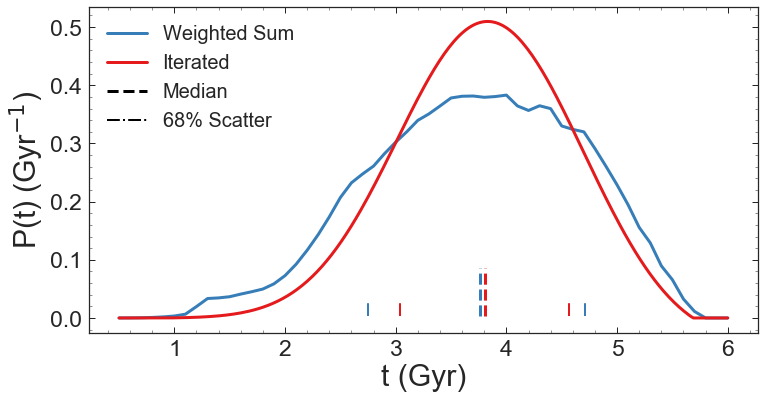

In [30]:
% matplotlib inline

plt.figure(figsize=[12,6])
plt.plot(X,Pos,color='#377eb8',label = 'Weighted Sum',lw=3)
plt.axvline(smed,0.05,0.2,linestyle='--',color='#377eb8',lw=3)
plt.axvline(smed-slr,0.05,0.1,linestyle='-.',color='#377eb8',lw=2)
plt.axvline(smed+shr,0.05,0.1,linestyle='-.',color='#377eb8',lw=2)

plt.plot(iterx,iterpos,color='#e41a1c',label = 'Iterated',lw=3)
plt.axvline(imed,0.05,0.2,linestyle='--',color='#e41a1c',lw=3)
plt.axvline(imed-ilr,0.05,0.1,linestyle='-.',color='#e41a1c',lw=2)
plt.axvline(imed+ihr,0.05,0.1,linestyle='-.',color='#e41a1c',lw=2)

# plt.plot(titerx,titerpos,color='#000000',label = 'test',lw=3)

plt.axvline(imed,5,20,linestyle='--',color='k',label='Median',lw=3)
plt.axvline(imed,5,20,linestyle='-.',color='k',label='68% Scatter',lw=2)

plt.tick_params(axis='both', which='major', labelsize=23)
plt.xlabel('t (Gyr)',fontsize = 30)
plt.ylabel('P(t) (Gyr$^{-1}$)',fontsize = 30)
plt.legend(fontsize = 20)
plt.savefig('../plots/stacking_exam_2.pdf',bbox_inches = 'tight')
